In [143]:
from analysis.analyze_results import *
from pathlib import Path
import matplotlib

In [144]:
# output_base_folder = Path("/iarai/work/logs/storage_benchmarking")
# output_base_folder = Path("/home/ivan/temp/temp-benchmarking")
output_base_folder = Path("/iarai/home/ivan.svogor/git/storage-benchmarking/src/benchmark_output")


## Dataloader benchmark (num workers, batch size)

**parameters**

| param | range |
| --- | --- |
| num_workers |0, 2, 4, 8, 16 | 
| batch_size | 8, 16, 32, 64 | 
| num_fetch_workers | 4, 8, 16, 32 | 
| fetch_impl | asyncio, threaded |
| dataset | s3,scratch |

Batch pool size is fixed to 10

**parameters explained**

| param | implementation | details | 
| --- | --- | --- |
| batch_pool_size | asyncio | Unused |
|  | threaded | Number of batches to fetch in parallel (normally, one batch is fetched, and items are downloaded (sequentially or in parallel). This implementation takes N batches and starts downloading items in parallel. Individual items are yielded and once a full batch is collected it is yielded.)|
| num_fetch_workers | asyncio | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls. Also, the number of tasks initially placed into the task (worker) queue.  |
|  | threaded | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls |

```bash
 for fetch_impl in "threaded" "asyncio"; do
   for storage in "s3" "scratch"; do
     for batch_size in 8 16 32 64; do
       for num_workers in 0 2 4 8 16; do
         for num_fetch_workers in 4 8 16 32; do
           python3 benchmark/benchmark_dataloader.py --output_base_folder /iarai/home/ivan.svogor/git/storage-benchmarking/src/benchmark_output/dataloader \
           --dataset "${storage}"  \
           --num_fetch_workers "${num_fetch_workers}" \
           --num_workers  "${num_workers}" \
           --repeat 1 \
           --num_batches 50 \
           --batch_size "${batch_size}" \
           --prefetch_factor 2 \
           --fetch_impl "${fetch_impl}"
         done
       done
     done
   done
 done
```

In [145]:
group_by_dataloader = ["dataset", "batch_size", "fetch_impl", "prefetch_factor"]

In [146]:
s3_folder_filter="e2e2610/*benchmark_e2e_s3*"

In [147]:
# df_dataloader_s3_full = extract_pandas(output_base_folder, folder_filter="e2e-vanilla/*benchmark_e2e_s3*")
df_dataloader = extract_pandas(output_base_folder, folder_filter=s3_folder_filter)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 369/369 [00:20<00:00, 18.38it/s]


In [148]:
# df_dataloader[df_dataloader["fetch_impl"]=="asyncio"].index
# df_dataloader = df_dataloader[(df_dataloader.fetch_impl == "vanilla") & 
#                               (df_dataloader.fetch_impl == "threaded")]
# df_dataloader[df_dataloader.fetch_impl == "threaded"]
# df_dataloader[df_dataloader.fetch_impl=="vanilla"]

In [149]:
df_dataloader_async=df_dataloader[df_dataloader["fetch_impl"]=="asyncio"]
df_dataloader = df_dataloader[(df_dataloader.fetch_impl == "vanilla") | 
                              (df_dataloader.fetch_impl == "threaded")]

df_dataloader_threaded=df_dataloader[df_dataloader["fetch_impl"]=="threaded"]
df_dataloader = df_dataloader[(df_dataloader.fetch_impl == "vanilla")]

df_dataloader_vanilla=df_dataloader[df_dataloader["fetch_impl"]=="vanilla"]
del df_dataloader

In [150]:
df_dataloader_async

,trace_name,trace_level,function_name,elapsed,time_start,time_end,process_time,process_time_start,process_time_end,pid,...,weight_decay,pretrained,system,node,release,version,machine,source_file,run,len
0,(8)-batch-to-device,8,batch_to_device,0.029781,1.635244e+09,1.635244e+09,0.029815,10.194593,10.224408,2818,...,0.0001,False,Linux,lnx-slim-2,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f121726_benchmark_e2e_s3_200_8_16_sync,NaN
1,(6)-advance,6,advance,65.578406,1.635243e+09,1.635244e+09,4.070050,6.471341,10.541391,2818,...,0.0001,False,Linux,lnx-slim-2,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f121726_benchmark_e2e_s3_200_8_16_sync,NaN
2,(8)-batch-to-device,8,batch_to_device,0.015812,1.635244e+09,1.635244e+09,0.015808,10.541649,10.557457,2818,...,0.0001,False,Linux,lnx-slim-2,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f121726_benchmark_e2e_s3_200_8_16_sync,NaN
3,(6)-advance,6,advance,0.251804,1.635244e+09,1.635244e+09,0.251213,10.541593,10.792806,2818,...,0.0001,False,Linux,lnx-slim-2,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f121726_benchmark_e2e_s3_200_8_16_sync,NaN
4,(8)-batch-to-device,8,batch_to_device,0.018969,1.635244e+09,1.635244e+09,0.019012,10.793185,10.812196,2818,...,0.0001,False,Linux,lnx-slim-2,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f121726_benchmark_e2e_s3_200_8_16_sync,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,(5)-get_item,5,__getitem__,0.138976,1.635245e+09,1.635245e+09,0.178297,9.786233,9.964530,19924,...,0.0001,False,Linux,lnx-slim-2,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f123106_benchmark_e2e_s3_800_8_16_sync,23451.0
197,(5)-get_item,5,__getitem__,0.188415,1.635245e+09,1.635245e+09,0.231616,9.735922,9.967539,19924,...,0.0001,False,Linux,lnx-slim-2,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f123106_benchmark_e2e_s3_800_8_16_sync,209297.0
198,(5)-get_item,5,__getitem__,0.199769,1.635245e+09,1.635245e+09,0.257301,9.711025,9.968326,19924,...,0.0001,False,Linux,lnx-slim-2,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f123106_benchmark_e2e_s3_800_8_16_sync,20112.0
199,(5)-get_item,5,__getitem__,0.134605,1.635245e+09,1.635245e+09,0.138948,9.840464,9.979413,19924,...,0.0001,False,Linux,lnx-slim-2,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f123106_benchmark_e2e_s3_800_8_16_sync,120469.0


In [151]:
df_s3_gpu_util = extract_gpu_utilization(output_base_folder, folder_filter=s3_folder_filter,device_id=2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:21<00:00,  2.34s/it]


In [152]:
df_s3_gpu_util

,run,gpu,gpu_mean,gpu_median,std
0,20211026f112518_benchmark_e2e_s3_200_8_16_sync,"[60.0, 70.0, 63.0, 62.0, 42.0, 44.0, 34.0, 52....",72.500000,83.0,26.030943
1,20211026f113329_benchmark_e2e_s3_400_8_16_sync,"[20.0, 74.0, 69.0, 100.0, 100.0, 70.0, 48.0, 9...",74.076923,82.5,27.175955
2,20211026f114311_benchmark_e2e_s3_800_8_16_sync,"[58.0, 88.0, 29.0, 71.0, 17.0, 36.0, 57.0, 99....",62.500000,62.0,25.811819
3,20211026f115752_benchmark_e2e_s3_200_8_16_sync,"[47.0, 66.0, 48.0, 66.0, 37.0, 91.0, 94.0, 97....",70.840000,67.5,24.150660
4,20211026f120411_benchmark_e2e_s3_400_8_16_sync,"[73.0, 100.0, 100.0, 67.0, 10.0, 75.0, 23.0, 8...",69.807692,74.0,29.650554
5,20211026f121045_benchmark_e2e_s3_800_8_16_sync,"[74.0, 100.0, 42.0, 84.0, 24.0, 96.0, 25.0, 65...",62.928571,65.0,27.022383
6,20211026f121726_benchmark_e2e_s3_200_8_16_sync,"[66.0, 85.0, 54.0, 63.0, 32.0, 60.0, 100.0, 10...",74.600000,85.0,26.329451
7,20211026f122344_benchmark_e2e_s3_400_8_16_sync,"[86.0, 100.0, 29.0, 71.0, 53.0, 52.0, 32.0, 84...",68.423077,68.0,26.096232
8,20211026f123106_benchmark_e2e_s3_800_8_16_sync,"[64.0, 100.0, 29.0, 80.0, 19.0, 100.0, 50.0, 1...",69.214286,72.0,28.488540


In [153]:
group_by_dataloader = ["dataset", "batch_size", "fetch_impl", "prefetch_factor"]

In [154]:
# print(df_dataloader.groupby(group_by_dataloader).groups.keys())

In [155]:
# group_by_dataloader = ["dataset",  "num_fetch_workers", "num_workers", "batch_pool", "fetch_impl", "gpu_median"]

In [156]:
df_dataloader_async = pd.merge(df_dataloader_async, df_s3_gpu_util, left_on='run', right_on='run')
df_dataloader_threaded = pd.merge(df_dataloader_threaded, df_s3_gpu_util, left_on='run', right_on='run')
df_dataloader_vanilla = pd.merge(df_dataloader_vanilla, df_s3_gpu_util, left_on='run', right_on='run')

In [157]:
display(get_run_stats(df_dataloader_async, group_by=group_by_dataloader))

downloaded data [B]  \
dataset batch_size fetch_impl prefetch_factor run                                                                   
s3      200        asyncio    16              20211026f121726_benchmark_e2e_s3_200_8_16_sync         2.567781e+09   
        400        asyncio    16              20211026f122344_benchmark_e2e_s3_400_8_16_sync         2.567781e+09   
        800        asyncio    16              20211026f123106_benchmark_e2e_s3_800_8_16_sync         2.567781e+09   

                                                                                                time_start  \
dataset batch_size fetch_impl prefetch_factor run                                                            
s3      200        asyncio    16              20211026f121726_benchmark_e2e_s3_200_8_16_sync  1.635243e+09   
        400        asyncio    16              20211026f122344_benchmark_e2e_s3_400_8_16_sync  1.635244e+09   
        800        asyncio    16              20211026f123106_benchmark_e2e_s3_800_8_16_sync  1.635244e+09   

                                                                                                  time_end  \
dataset batch_size fetch_impl prefetch_factor run                                                            
s3      200        asyncio    16              20211026f121726_benchmark_e2e_s3_200_8_16_sync  1.635244e+09   
        400        asyncio    16              20211026f122344_benchmark_e2e_s3_400_8_16_sync  1.635244e+09   
        800        asyncio    16              20211026f123106_benchmark_e2e_s3_800_8_16_sync  1.635245e+09   

                                                                                              total_elpased_time [s]  \
dataset batch_size fetch_impl prefetch_factor run                                                                      
s3      200        asyncio    16              20211026f121726_benchmark_e2e_s3_200_8_16_sync              370.209309   
        400        asyncio    16              20211026f122344_benchmark_e2e_s3_400_8_16_sync              434.845676   
        800        asyncio    16              20211026f123106_benchmark_e2e_s3_800_8_16_sync              394.196163   

                                                                                              downloaded data [MB]  \
dataset batch_size fetch_impl prefetch_factor run                                                                    
s3      200        asyncio    16              20211026f121726_benchmark_e2e_s3_200_8_16_sync           2567.781305   
        400        asyncio    16              20211026f122344_benchmark_e2e_s3_400_8_16_sync           2567.781305   
        800        asyncio    16              20211026f123106_benchmark_e2e_s3_800_8_16_sync           2567.781305   

                                                                                              throughput [MBit/s]  
dataset batch_size fetch_impl prefetch_factor run                                                                  
s3      200        asyncio    16              20211026f121726_benchmark_e2e_s3_200_8_16_sync            55.488206  
        400        asyncio    16              20211026f122344_benchmark_e2e_s3_400_8_16_sync            47.240324  
        800        asyncio    16              20211026f123106_benchmark_e2e_s3_800_8_16_sync            52.111746

In [158]:
display(get_run_stats(df_dataloader_threaded, group_by=group_by_dataloader))

downloaded data [B]  \
dataset batch_size fetch_impl prefetch_factor run                                                                   
s3      200        threaded   16              20211026f115752_benchmark_e2e_s3_200_8_16_sync         2.738559e+09   
        400        threaded   16              20211026f120411_benchmark_e2e_s3_400_8_16_sync         2.810417e+09   
        800        threaded   16              20211026f121045_benchmark_e2e_s3_800_8_16_sync         2.964142e+09   

                                                                                                time_start  \
dataset batch_size fetch_impl prefetch_factor run                                                            
s3      200        threaded   16              20211026f115752_benchmark_e2e_s3_200_8_16_sync  1.635242e+09   
        400        threaded   16              20211026f120411_benchmark_e2e_s3_400_8_16_sync  1.635243e+09   
        800        threaded   16              20211026f121045_benchmark_e2e_s3_800_8_16_sync  1.635243e+09   

                                                                                                  time_end  \
dataset batch_size fetch_impl prefetch_factor run                                                            
s3      200        threaded   16              20211026f115752_benchmark_e2e_s3_200_8_16_sync  1.635243e+09   
        400        threaded   16              20211026f120411_benchmark_e2e_s3_400_8_16_sync  1.635243e+09   
        800        threaded   16              20211026f121045_benchmark_e2e_s3_800_8_16_sync  1.635243e+09   

                                                                                              total_elpased_time [s]  \
dataset batch_size fetch_impl prefetch_factor run                                                                      
s3      200        threaded   16              20211026f115752_benchmark_e2e_s3_200_8_16_sync              371.535024   
        400        threaded   16              20211026f120411_benchmark_e2e_s3_400_8_16_sync              386.186872   
        800        threaded   16              20211026f121045_benchmark_e2e_s3_800_8_16_sync              391.923570   

                                                                                              downloaded data [MB]  \
dataset batch_size fetch_impl prefetch_factor run                                                                    
s3      200        threaded   16              20211026f115752_benchmark_e2e_s3_200_8_16_sync            2738.55920   
        400        threaded   16              20211026f120411_benchmark_e2e_s3_400_8_16_sync            2810.41742   
        800        threaded   16              20211026f121045_benchmark_e2e_s3_800_8_16_sync            2964.14246   

                                                                                              throughput [MBit/s]  
dataset batch_size fetch_impl prefetch_factor run                                                                  
s3      200        threaded   16              20211026f115752_benchmark_e2e_s3_200_8_16_sync            58.967452  
        400        threaded   16              20211026f120411_benchmark_e2e_s3_400_8_16_sync            58.218808  
        800        threaded   16              20211026f121045_benchmark_e2e_s3_800_8_16_sync            60.504500

In [159]:
display(get_thread_stats(df_dataloader_async,group_by=group_by_dataloader))

,time_start_thread,time_end_thread,total_elapsed_thread,dataset,batch_size,fetch_impl,prefetch_factor,elapsed_thread,elapsed_processing
threading_ident,,,,,,,,,
139619598993152,1.635244e+09,1.635244e+09,28.785968,s3,400,asyncio,16,29.294198,0.982651
139619607385856,1.635244e+09,1.635244e+09,28.592735,s3,400,asyncio,16,29.125151,0.981720
139619615778560,1.635244e+09,1.635244e+09,28.537495,s3,400,asyncio,16,29.039880,0.982700
139619624171264,1.635244e+09,1.635244e+09,28.526393,s3,400,asyncio,16,29.036089,0.982446
139619681150720,1.635244e+09,1.635244e+09,28.456574,s3,400,asyncio,16,28.959790,0.982624
...,...,...,...,...,...,...,...,...,...
140711164892928,1.635243e+09,1.635244e+09,25.133880,s3,200,asyncio,16,25.782789,0.974832
140711173285632,1.635243e+09,1.635244e+09,24.839007,s3,200,asyncio,16,25.853084,0.960775
140711181678336,1.635243e+09,1.635244e+09,25.059492,s3,200,asyncio,16,25.893173,0.967803


### S3 Event plots of dataloading

#### S3


In [160]:
df_dataloader_s3_async=df_dataloader_async[df_dataloader_async["dataset"]=="s3"]
df_dataloader_s3_threaded=df_dataloader_threaded[df_dataloader_threaded["dataset"]=="s3"]
df_dataloader_s3_vanilla=df_dataloader_vanilla[df_dataloader_vanilla["dataset"]=="s3"]

In [161]:
num_workers = np.unique(df_dataloader_s3_async["num_workers"].to_numpy())
fetch_workers = np.unique(df_dataloader_s3_async["num_fetch_workers"].to_numpy())
batch_sizes = np.unique(df_dataloader_s3_async["batch_size"].to_numpy())
print(num_workers, fetch_workers, batch_sizes)

[8] [16] [200 400 800]


In [162]:
def print_rate_table(df):
    rate_matrix = pd.DataFrame(columns=["batch_size", "num_fetch_workers", "num_workers", "rate"])
    for i, batch_size in enumerate(batch_sizes):
        for j, prefetch_factor in enumerate(np.unique(df["prefetch_factor"].to_numpy())):
            run = df[(df["num_fetch_workers"]==fetch_workers[0]) & 
                     (df["prefetch_factor"]==prefetch_factor) &
                     (df["num_workers"]==num_workers[0]) &
                     (df["batch_size"]==batch_size)]["run"].iloc[0]
            mbps, mbitps = plot_events_timeline(df[df["run"]==run], 
                                                summary_only=True, 
                                                verbose=False)
            if "GB" in list(mbitps)[0]:
                r = float(list(mbitps)[0].replace("GB", "")) * 1000
            else:
                if list(mbitps)[0].replace("MB", "") != "0 Bytes":
                    r = float(list(mbitps)[0].replace("MB", ""))
                else: 
                    r = 0
            median = df_s3_gpu_util[df_s3_gpu_util["run"]==run]["gpu_median"]
            rate_matrix = rate_matrix.append({'batch_size': batch_size, 
                                              'num_fetch_workers': fetch_workers, 
                                              'pf': prefetch_factor, 
                                              'num_workers': num_workers,
                                              'gpu_median': list(median)[0],
                                              'rate': r}, ignore_index=True)    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(rate_matrix.sort_values(["batch_size"], ascending=False))
    return rate_matrix

#### Threaded

In [163]:
print(np.unique(df_dataloader_s3_threaded["num_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_threaded["num_fetch_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_threaded["batch_size"].to_numpy()))
print(np.unique(df_dataloader_s3_threaded["prefetch_factor"].to_numpy()))

[8]
[16]
[200 400 800]
[16]


In [164]:
s3_rate_matrix_asyncio = print_rate_table(df_dataloader_s3_async)

  batch_size num_fetch_workers num_workers  rate  gpu_median    pf
2        800              [16]         [8]  52.1        72.0  16.0
1        400              [16]         [8]  47.2        68.0  16.0
0        200              [16]         [8]  55.5        85.0  16.0


In [165]:
s3_rate_matrix_threaded = print_rate_table(df_dataloader_s3_threaded)

  batch_size num_fetch_workers num_workers  rate  gpu_median    pf
2        800              [16]         [8]  60.5        65.0  16.0
1        400              [16]         [8]  58.2        74.0  16.0
0        200              [16]         [8]  59.0        67.5  16.0


In [166]:
s3_rate_matrix_vanilla = print_rate_table(df_dataloader_s3_vanilla)

  batch_size num_fetch_workers num_workers  rate  gpu_median    pf
2        800              [16]         [8]  23.5        62.0  16.0
1        400              [16]         [8]  33.8        82.5  16.0
0        200              [16]         [8]  37.8        83.0  16.0


In [167]:
s3_both = pd.concat([s3_rate_matrix_asyncio, 
                     s3_rate_matrix_threaded[["rate", "gpu_median"]],
                     s3_rate_matrix_vanilla[["rate", "gpu_median"]]], 
                     ignore_index = True, axis = 1)
# s3_both['diff'] = s3_both.apply(lambda row: float(row[4] - row[3]) , axis = 1)
s3_both.columns = ['batch_size', 'num_fetch_workers', 'num_workers', 'a_rate', 'a_gpu', 'pf', 't_rate', 't_gpu', 'v_rate', 'v_gpu']
# both["diff"] = both["diff"].clip(lower=0)
# # both
s3_both.sort_values(["pf"], ascending=True)

,batch_size,num_fetch_workers,num_workers,a_rate,a_gpu,pf,t_rate,t_gpu,v_rate,v_gpu
0,200,[16],[8],55.5,85.0,16.0,59.0,67.5,37.8,83.0
1,400,[16],[8],47.2,68.0,16.0,58.2,74.0,33.8,82.5
2,800,[16],[8],52.1,72.0,16.0,60.5,65.0,23.5,62.0


/tmp/ipykernel_22331/3384202041.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+batch_sizes, fontdict=None)


Text(0.5, 1.0, 'Throughput with increasing batch size')

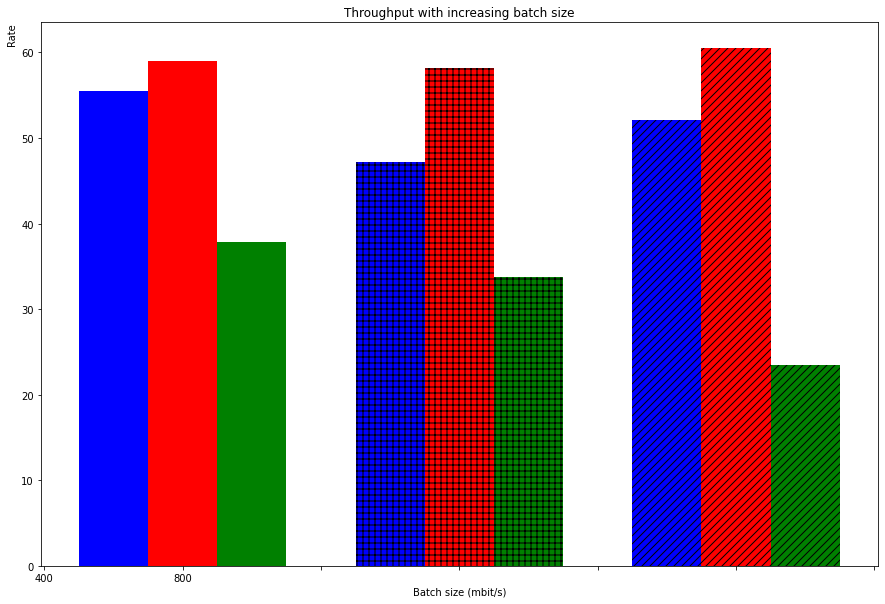

In [169]:
fig, ax = plt.subplots(figsize=(15, 10))
# ax.axis(ymin=0.0, ymax=0.01)
for i, (bs, hsh) in enumerate(zip(batch_sizes, ["", "++", "///", ".", "o", "x", "\\"])):
#     p = s3_both[(s3_both["pf"]==4) & (s3_both["batch_size"]==bs)]
#     ax.bar(x=i-0.25, height=p["a_rate"], width=0.25, color="blue", hatch=hsh)
#     ax.bar(x=i, height=p["t_rate"], width=0.25, color="red", hatch=hsh)
#     ax.bar(x=i+0.25, height=p["v_rate"], width=0.25, color="green", hatch=hsh)
    p = s3_both[(s3_both["pf"]==16) & (s3_both["batch_size"]==bs)]
    ax.bar(x=i+4-0.25, height=p["a_rate"], width=0.25, color="blue", hatch=hsh)
    ax.bar(x=i+4, height=p["t_rate"], width=0.25, color="red", hatch=hsh)
    ax.bar(x=i+4+0.25, height=p["v_rate"], width=0.25, color="green", hatch=hsh)

ax.set_xlabel("Batch size (mbit/s)", loc="center")
ax.set_xticklabels([0]+batch_sizes, fontdict=None)
ax.set_ylabel("Rate", loc="top")
ax.set_title(f"Throughput with increasing batch size", loc='center')

/tmp/ipykernel_22331/1984535441.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)


Text(0.5, 1.0, 'GPU utilization vs batch size: blue = asyncio, red = threaded, green = vanilla')

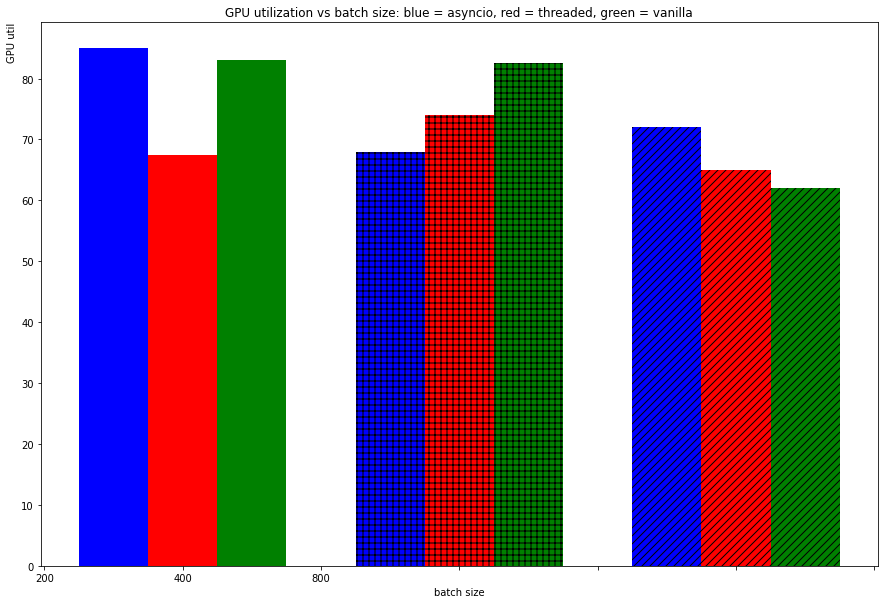

In [170]:
fig, ax = plt.subplots(figsize=(15, 10))
# ax.axis(ymin=0.0, ymax=0.01)
for i, (bs, hsh) in enumerate(zip(batch_sizes, ["", "++", "///", ".", "o", "x", "\\"])):
#     p = s3_both[(s3_both["pf"]==2) & (s3_both["batch_size"]==bs)]
#     ax.bar(x=i-0.25, height=p["a_gpu"], width=0.25, color="blue", hatch=hsh)
#     ax.bar(x=i, height=p["t_gpu"], width=0.25, color="red", hatch=hsh)
#     ax.bar(x=i+0.25, height=p["v_gpu"], width=0.25, color="green", hatch=hsh)

    p = s3_both[(s3_both["pf"]==16) & (s3_both["batch_size"]==bs)]
    ax.bar(x=i+4-0.25, height=p["a_gpu"], width=0.25, color="blue", hatch=hsh)
    ax.bar(x=i+4, height=p["t_gpu"], width=0.25, color="red", hatch=hsh)
    ax.bar(x=i+4+0.25, height=p["v_gpu"], width=0.25, color="green", hatch=hsh)

ax.set_xlabel("batch size", loc="center")
ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)
ax.set_ylabel("GPU util", loc="top")
ax.set_title(f"GPU utilization vs batch size: blue = asyncio, red = threaded, green = vanilla", loc='center')


25000
Lines num: 25640


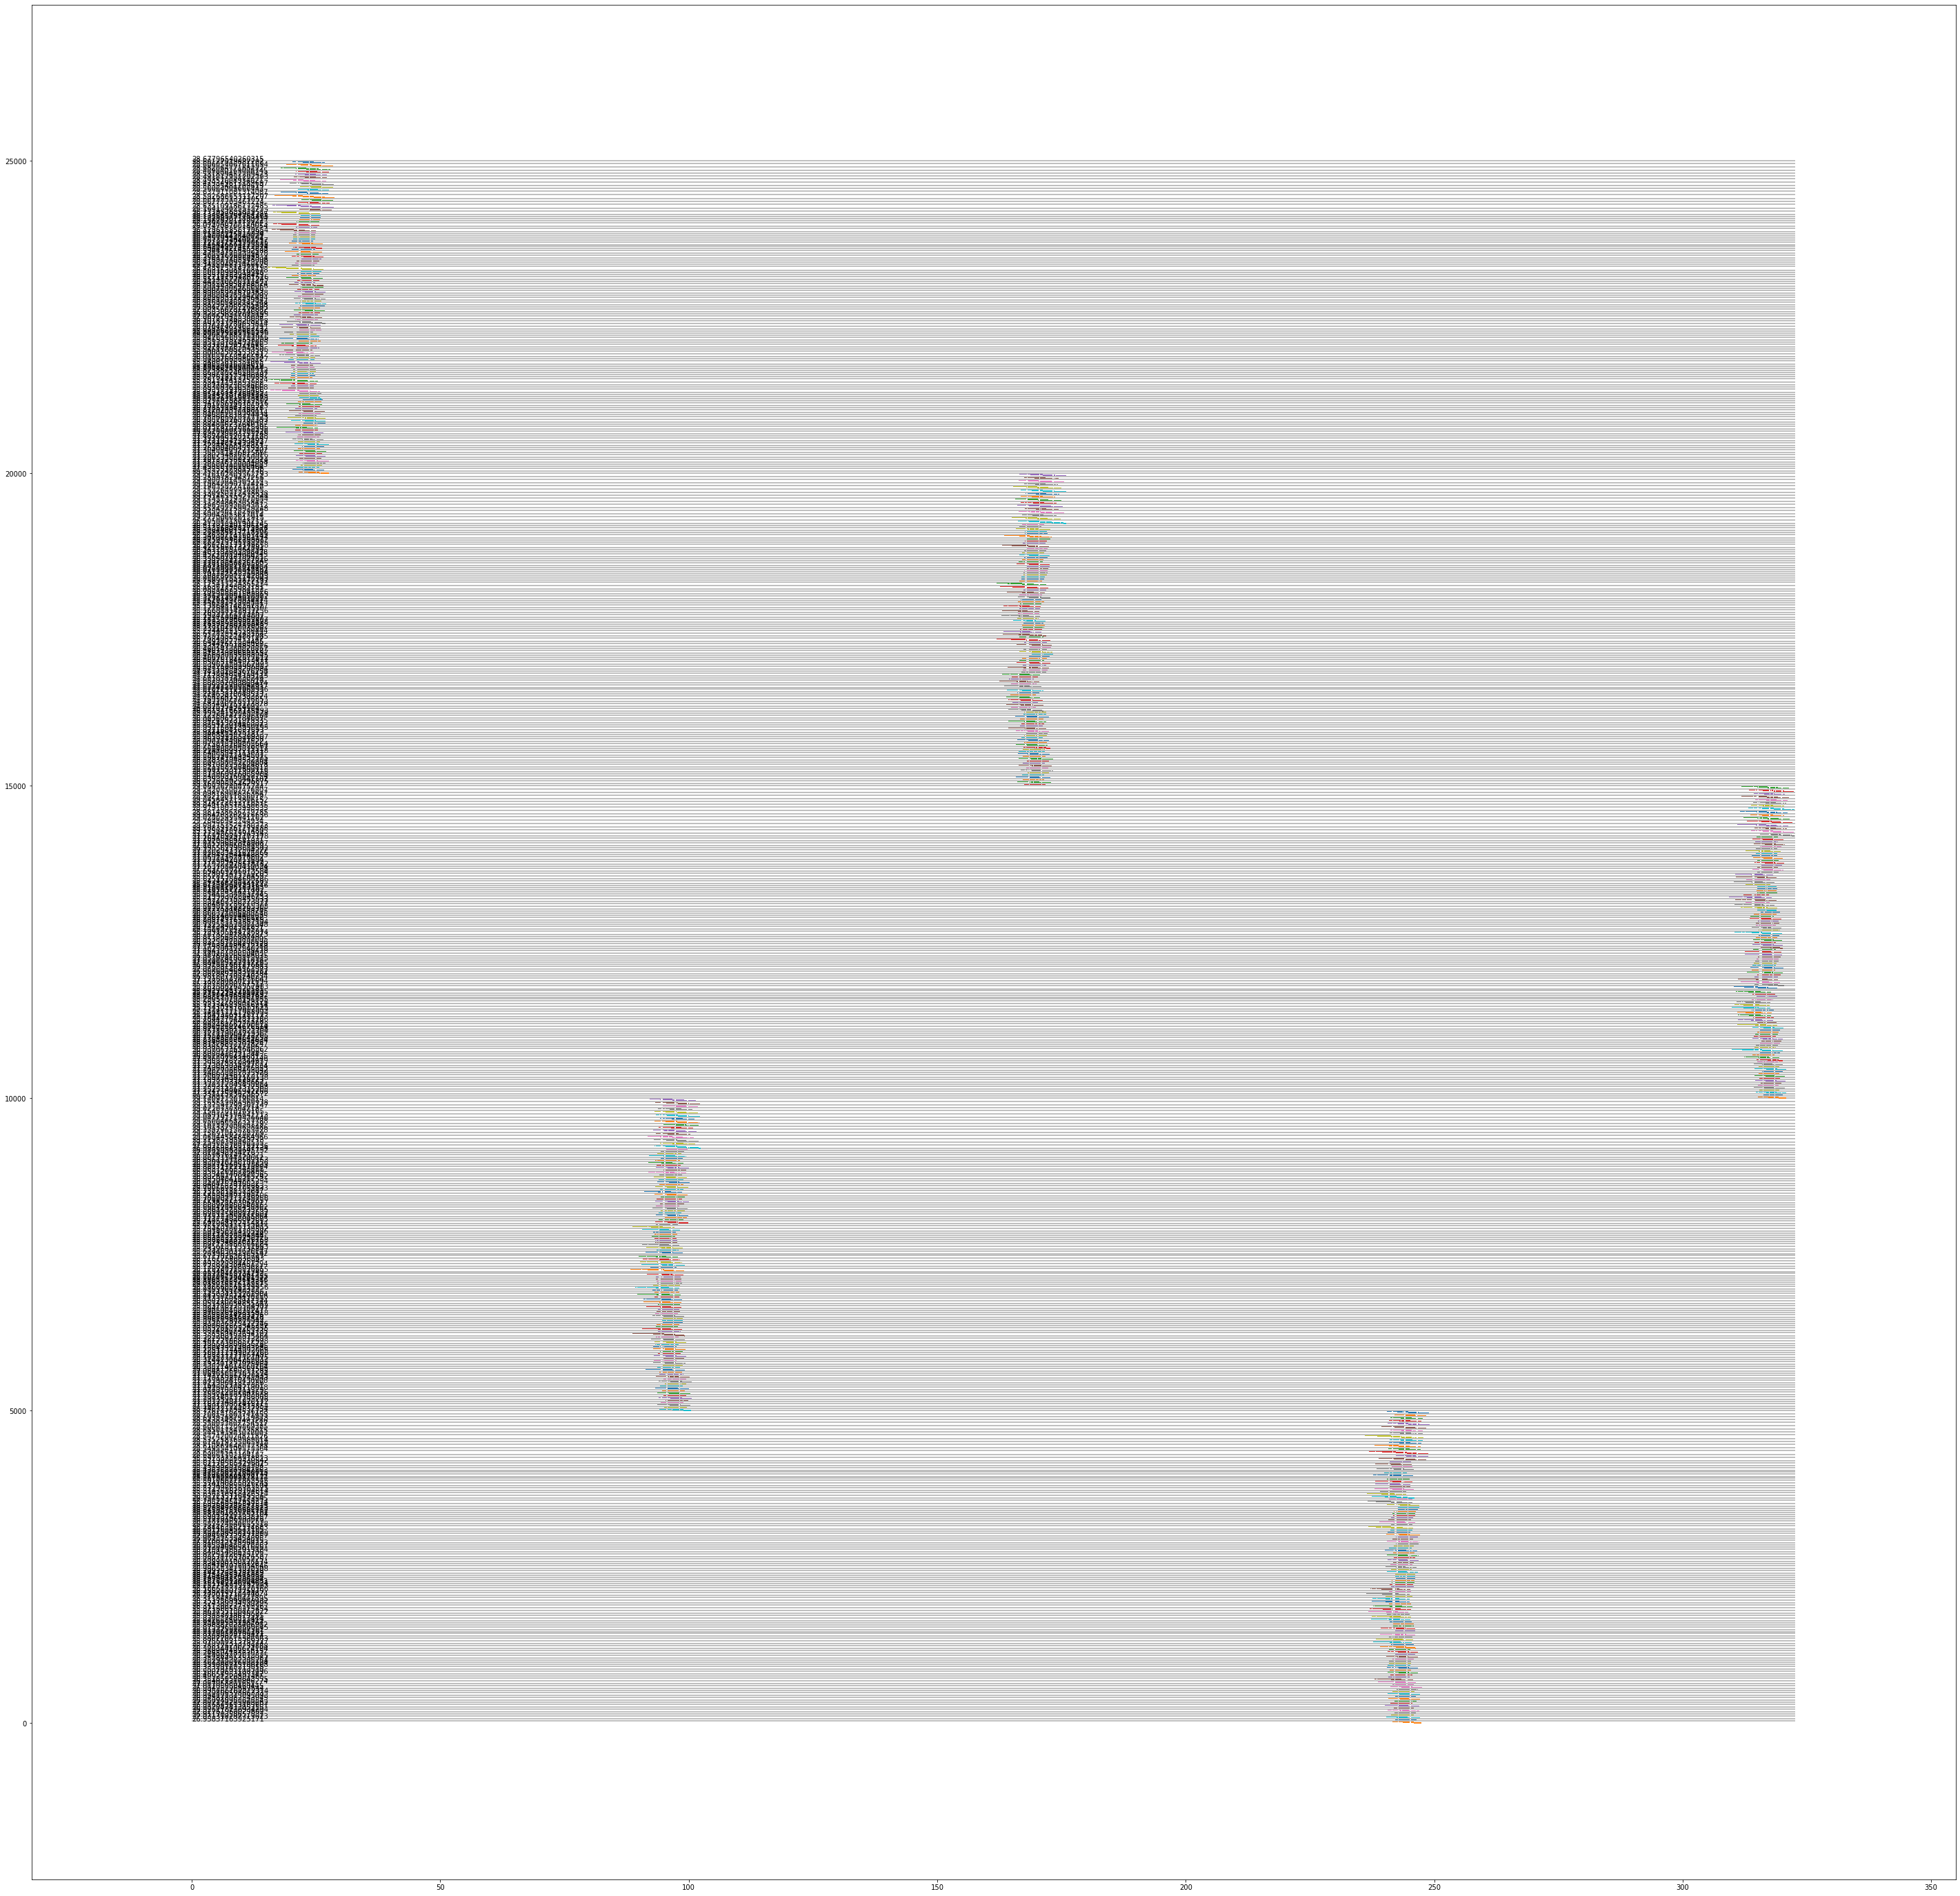

In [171]:
run = df_dataloader_async[(df_dataloader_async["num_workers"]==8) & 
                          (df_dataloader_async["batch_size"]==200)]["run"].iloc[0]
len(run)
plot_events_timeline_detailed(df_dataloader_async[df_dataloader_async["run"]==run], 
                              filter_function="__getitem__")


20211026f120411_benchmark_e2e_s3_400_8_16_sync
[200 400 800]
25000
Lines num: 25873
65
Lines num: 66
65
Lines num: 66
total_elapsed=0:06:26.186872
total_bytes=2.8 GB
overall rate {'7.3 MB'}/s
overall rate {'58.2 MB'}it/s


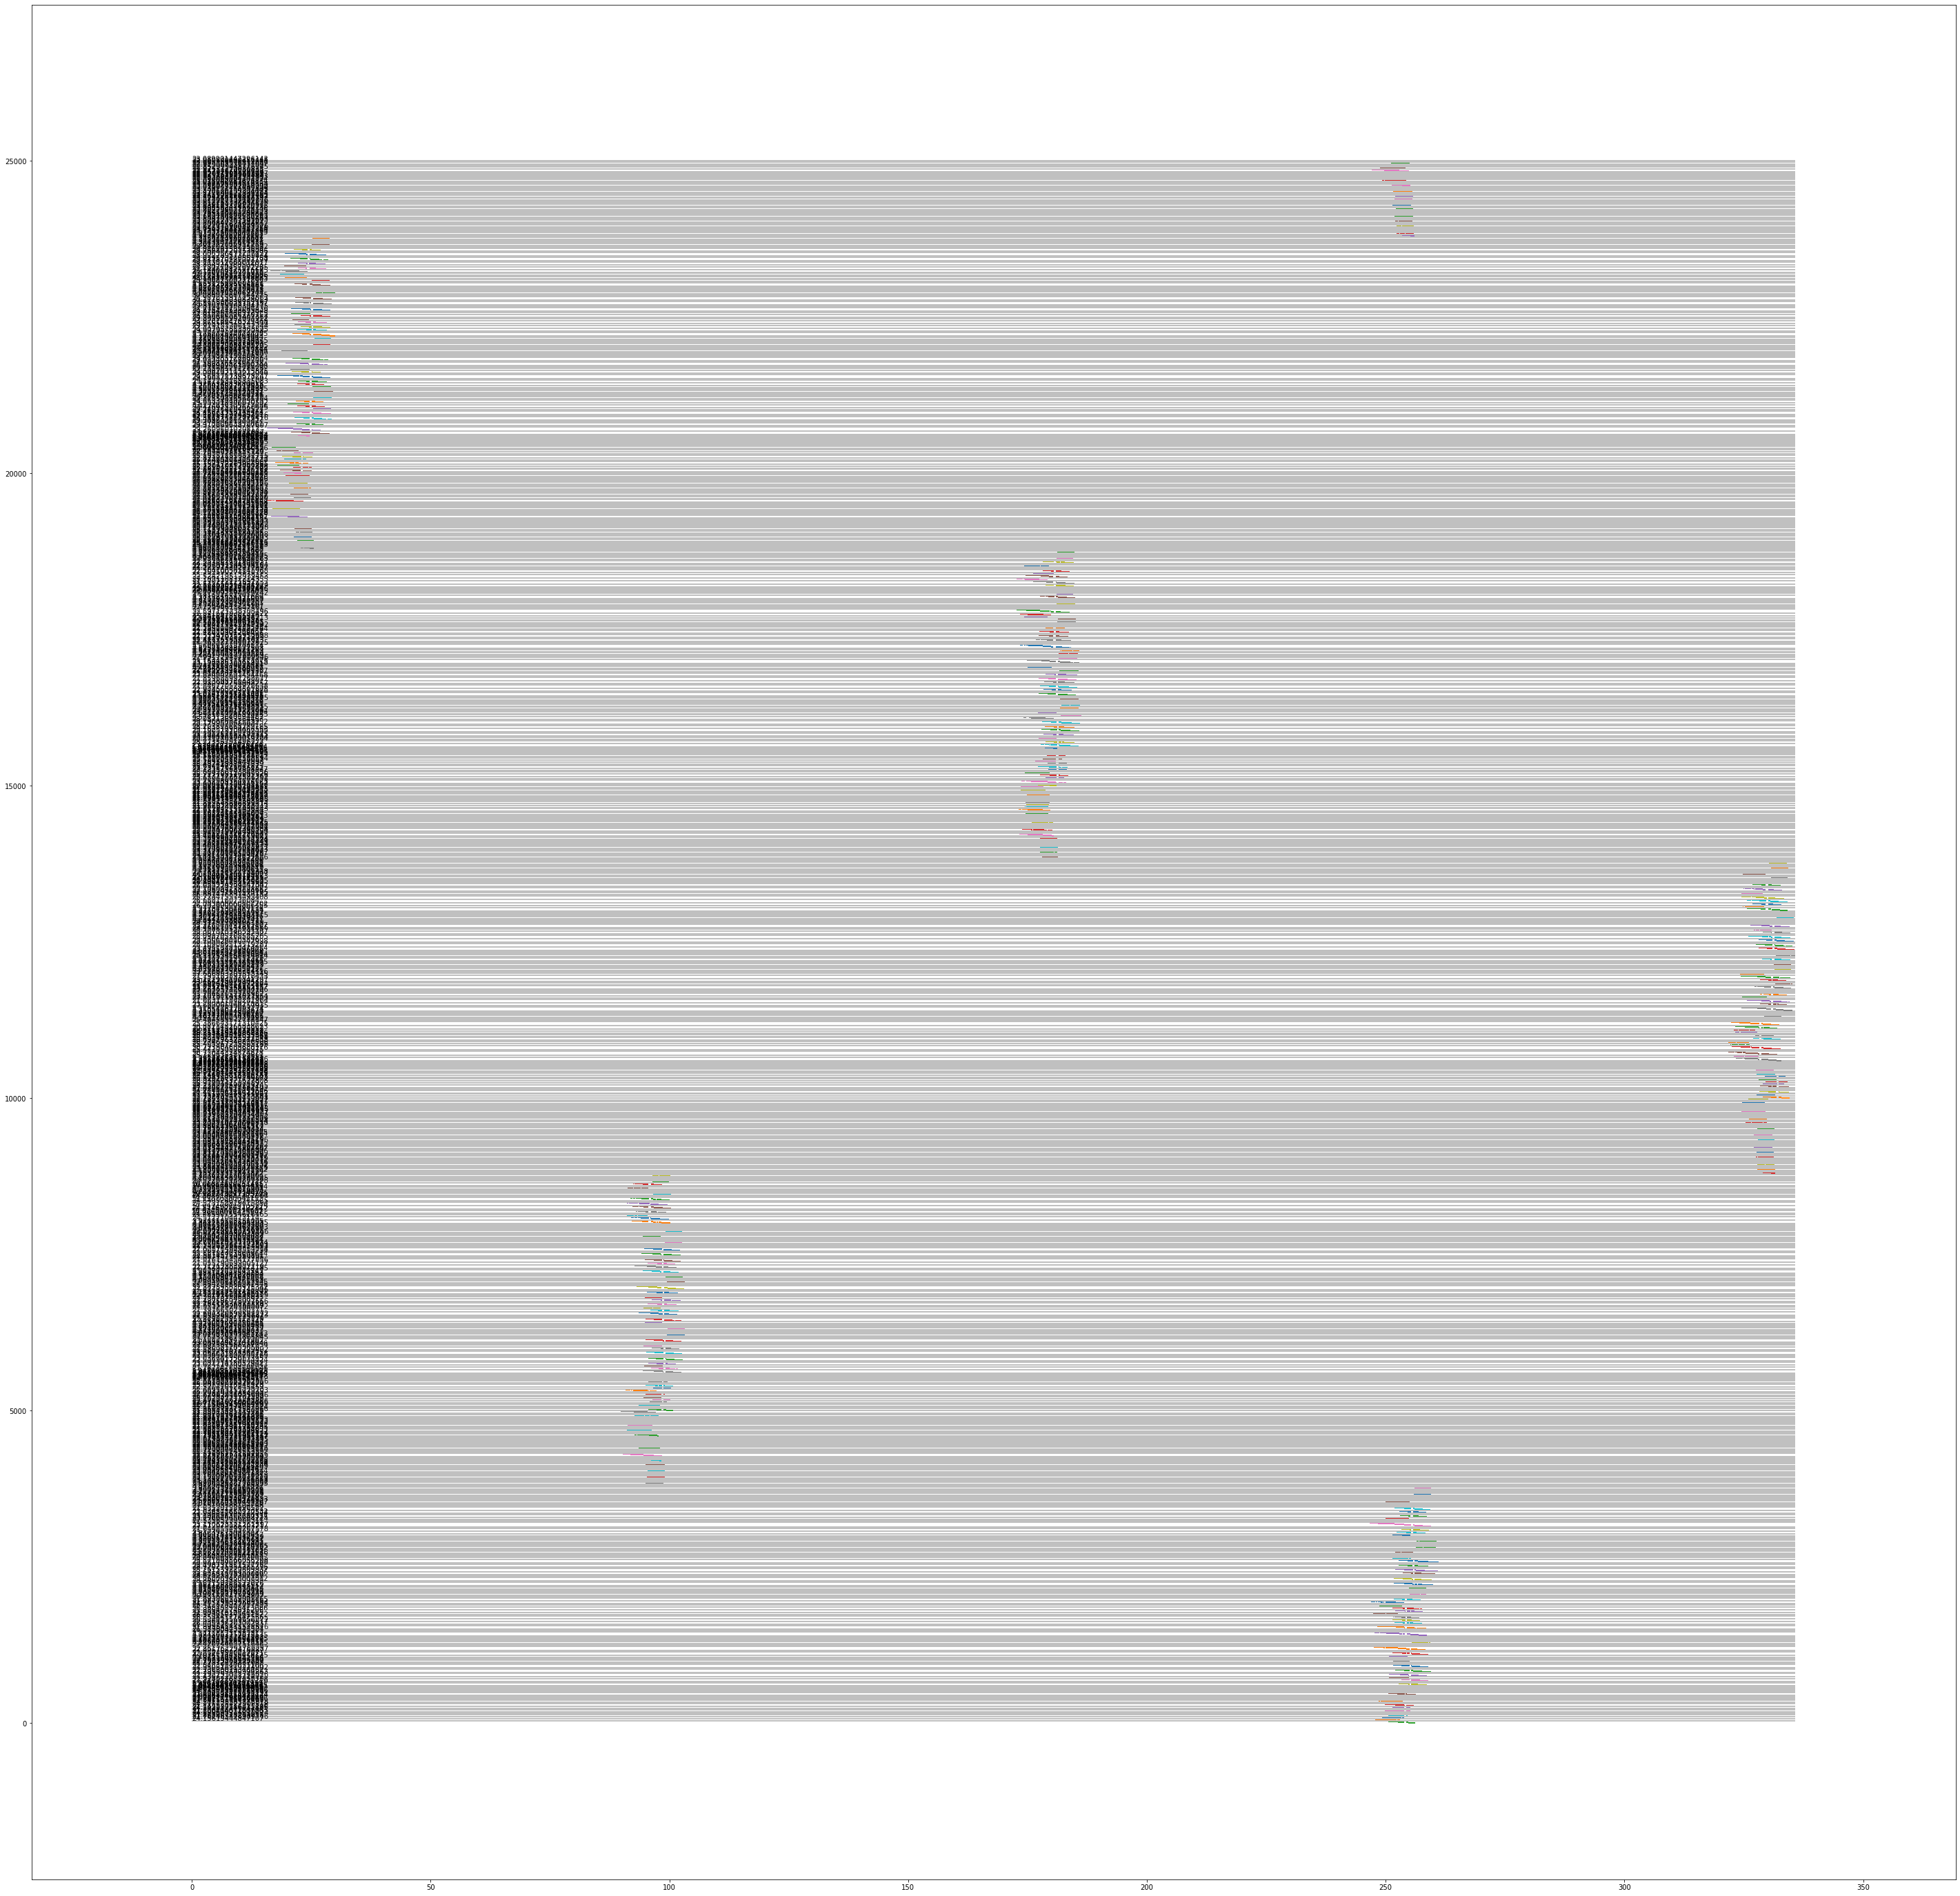

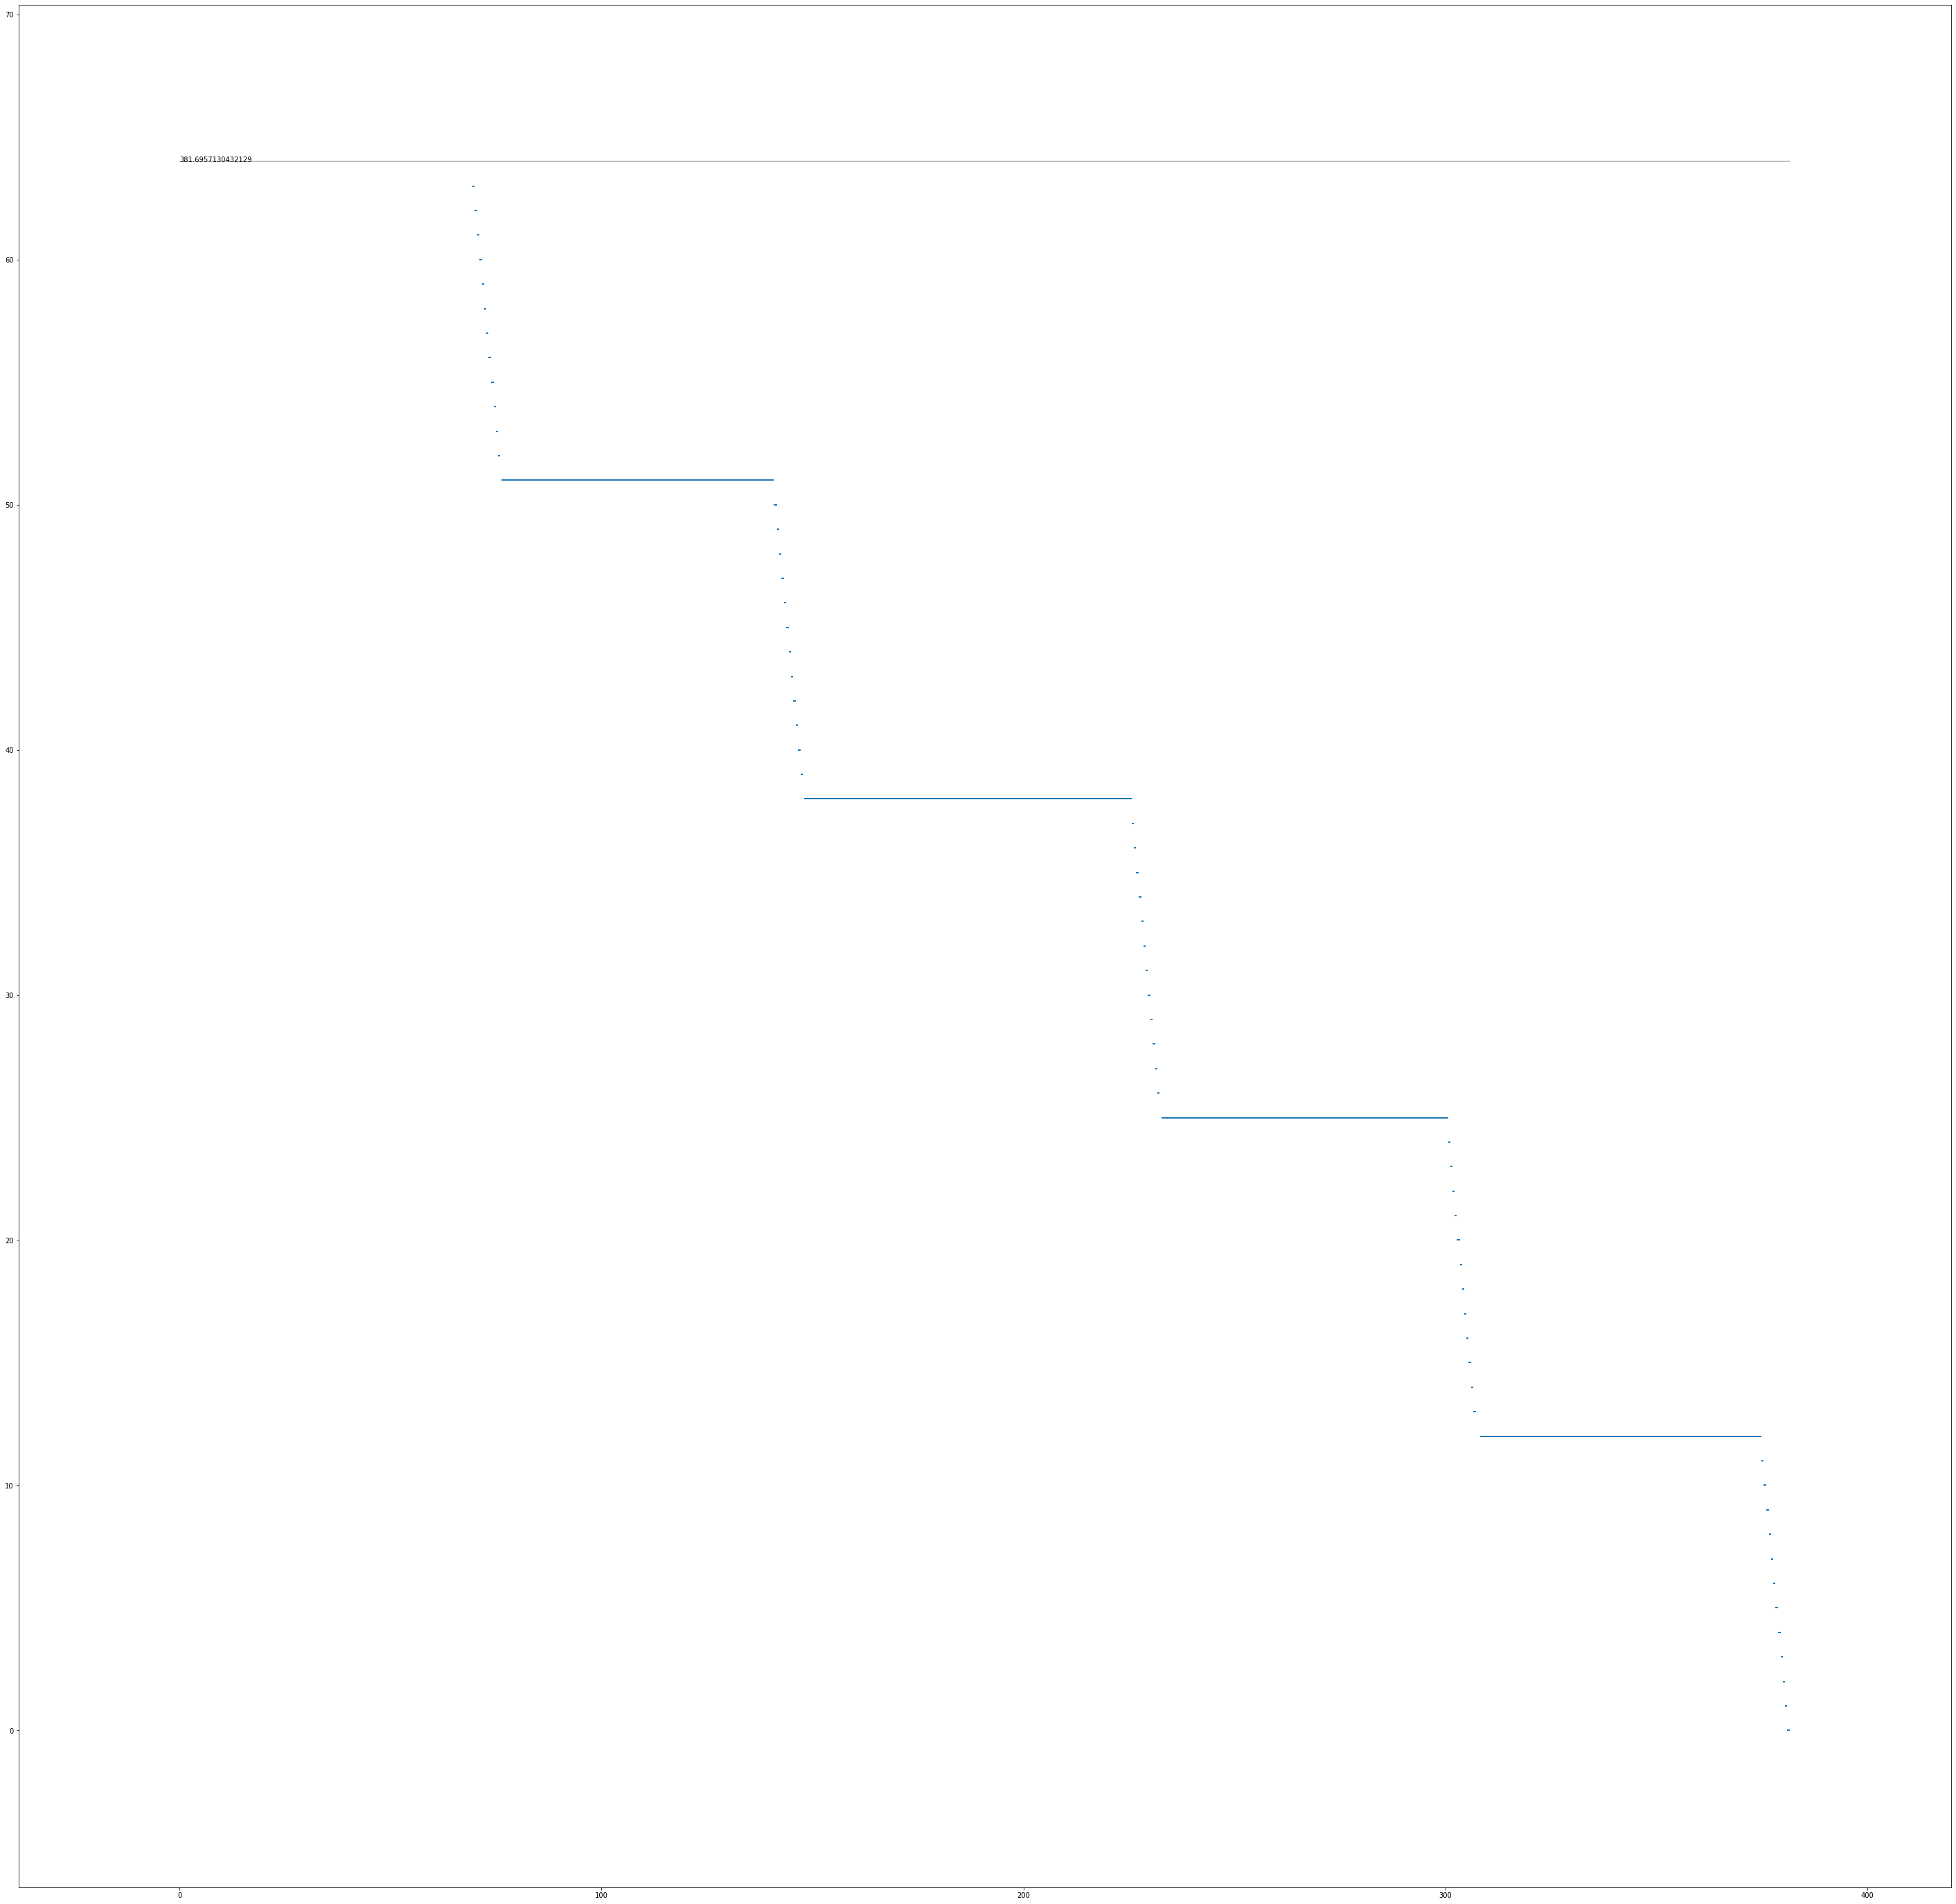

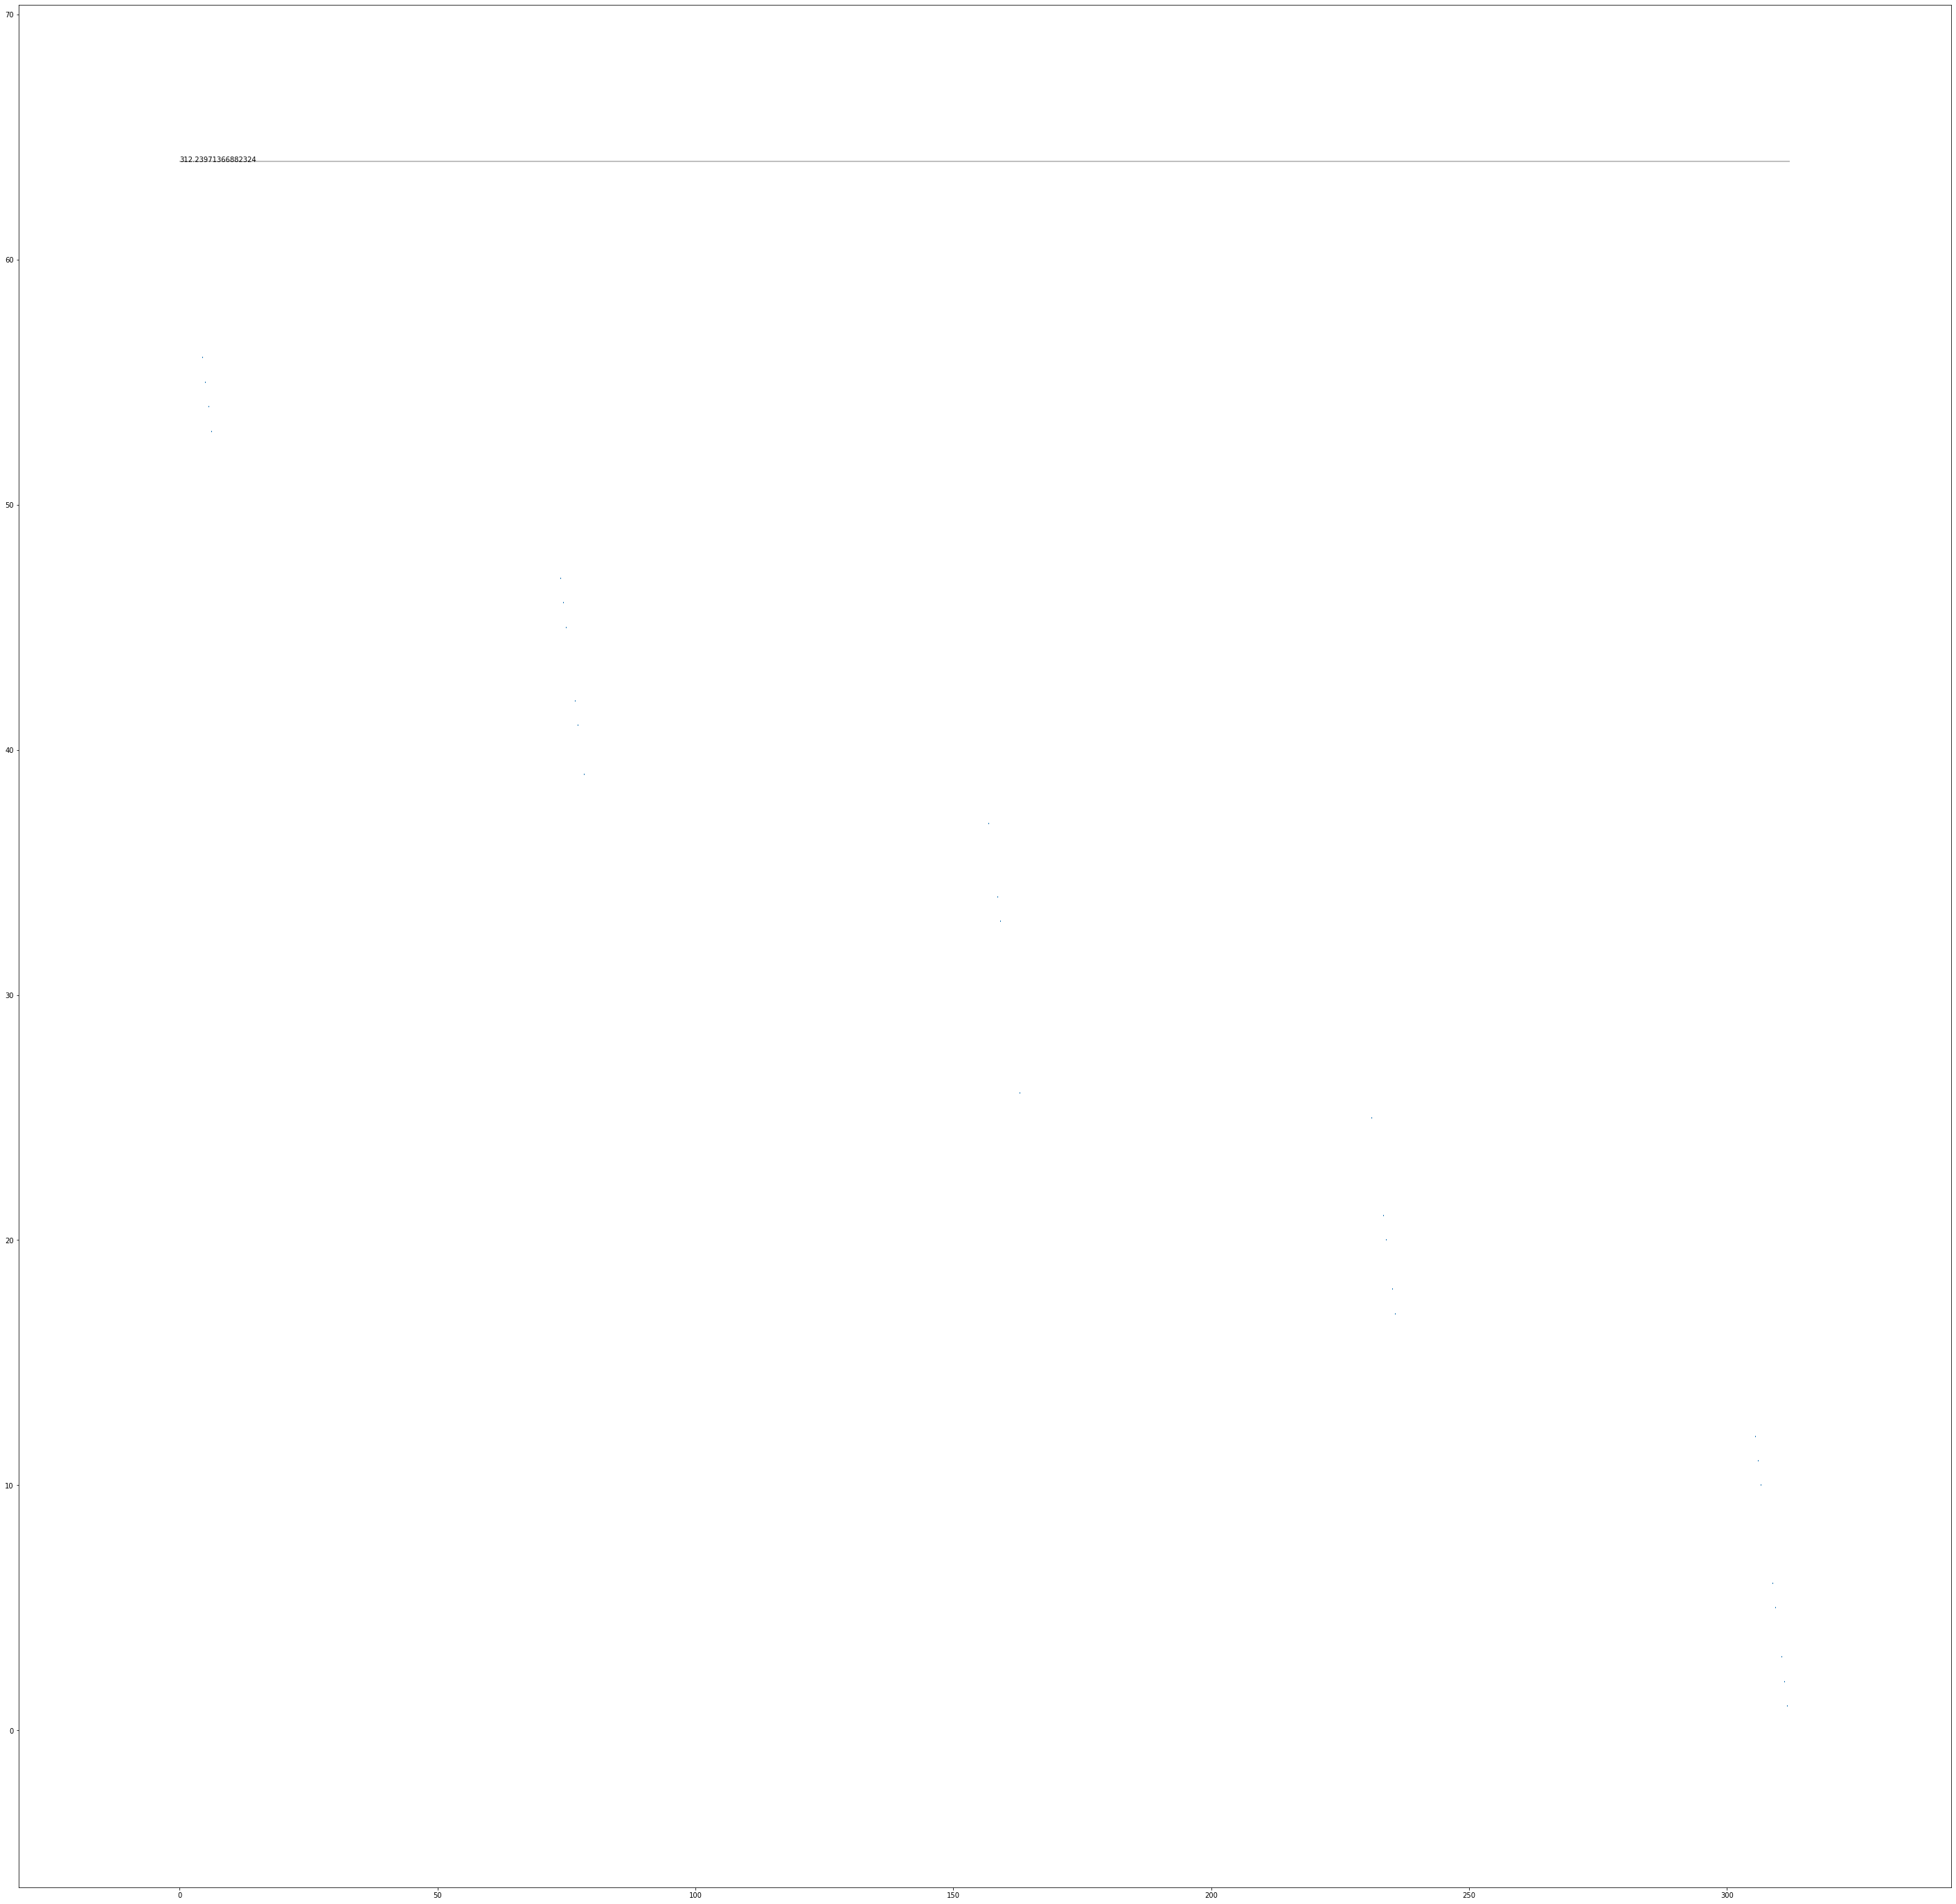

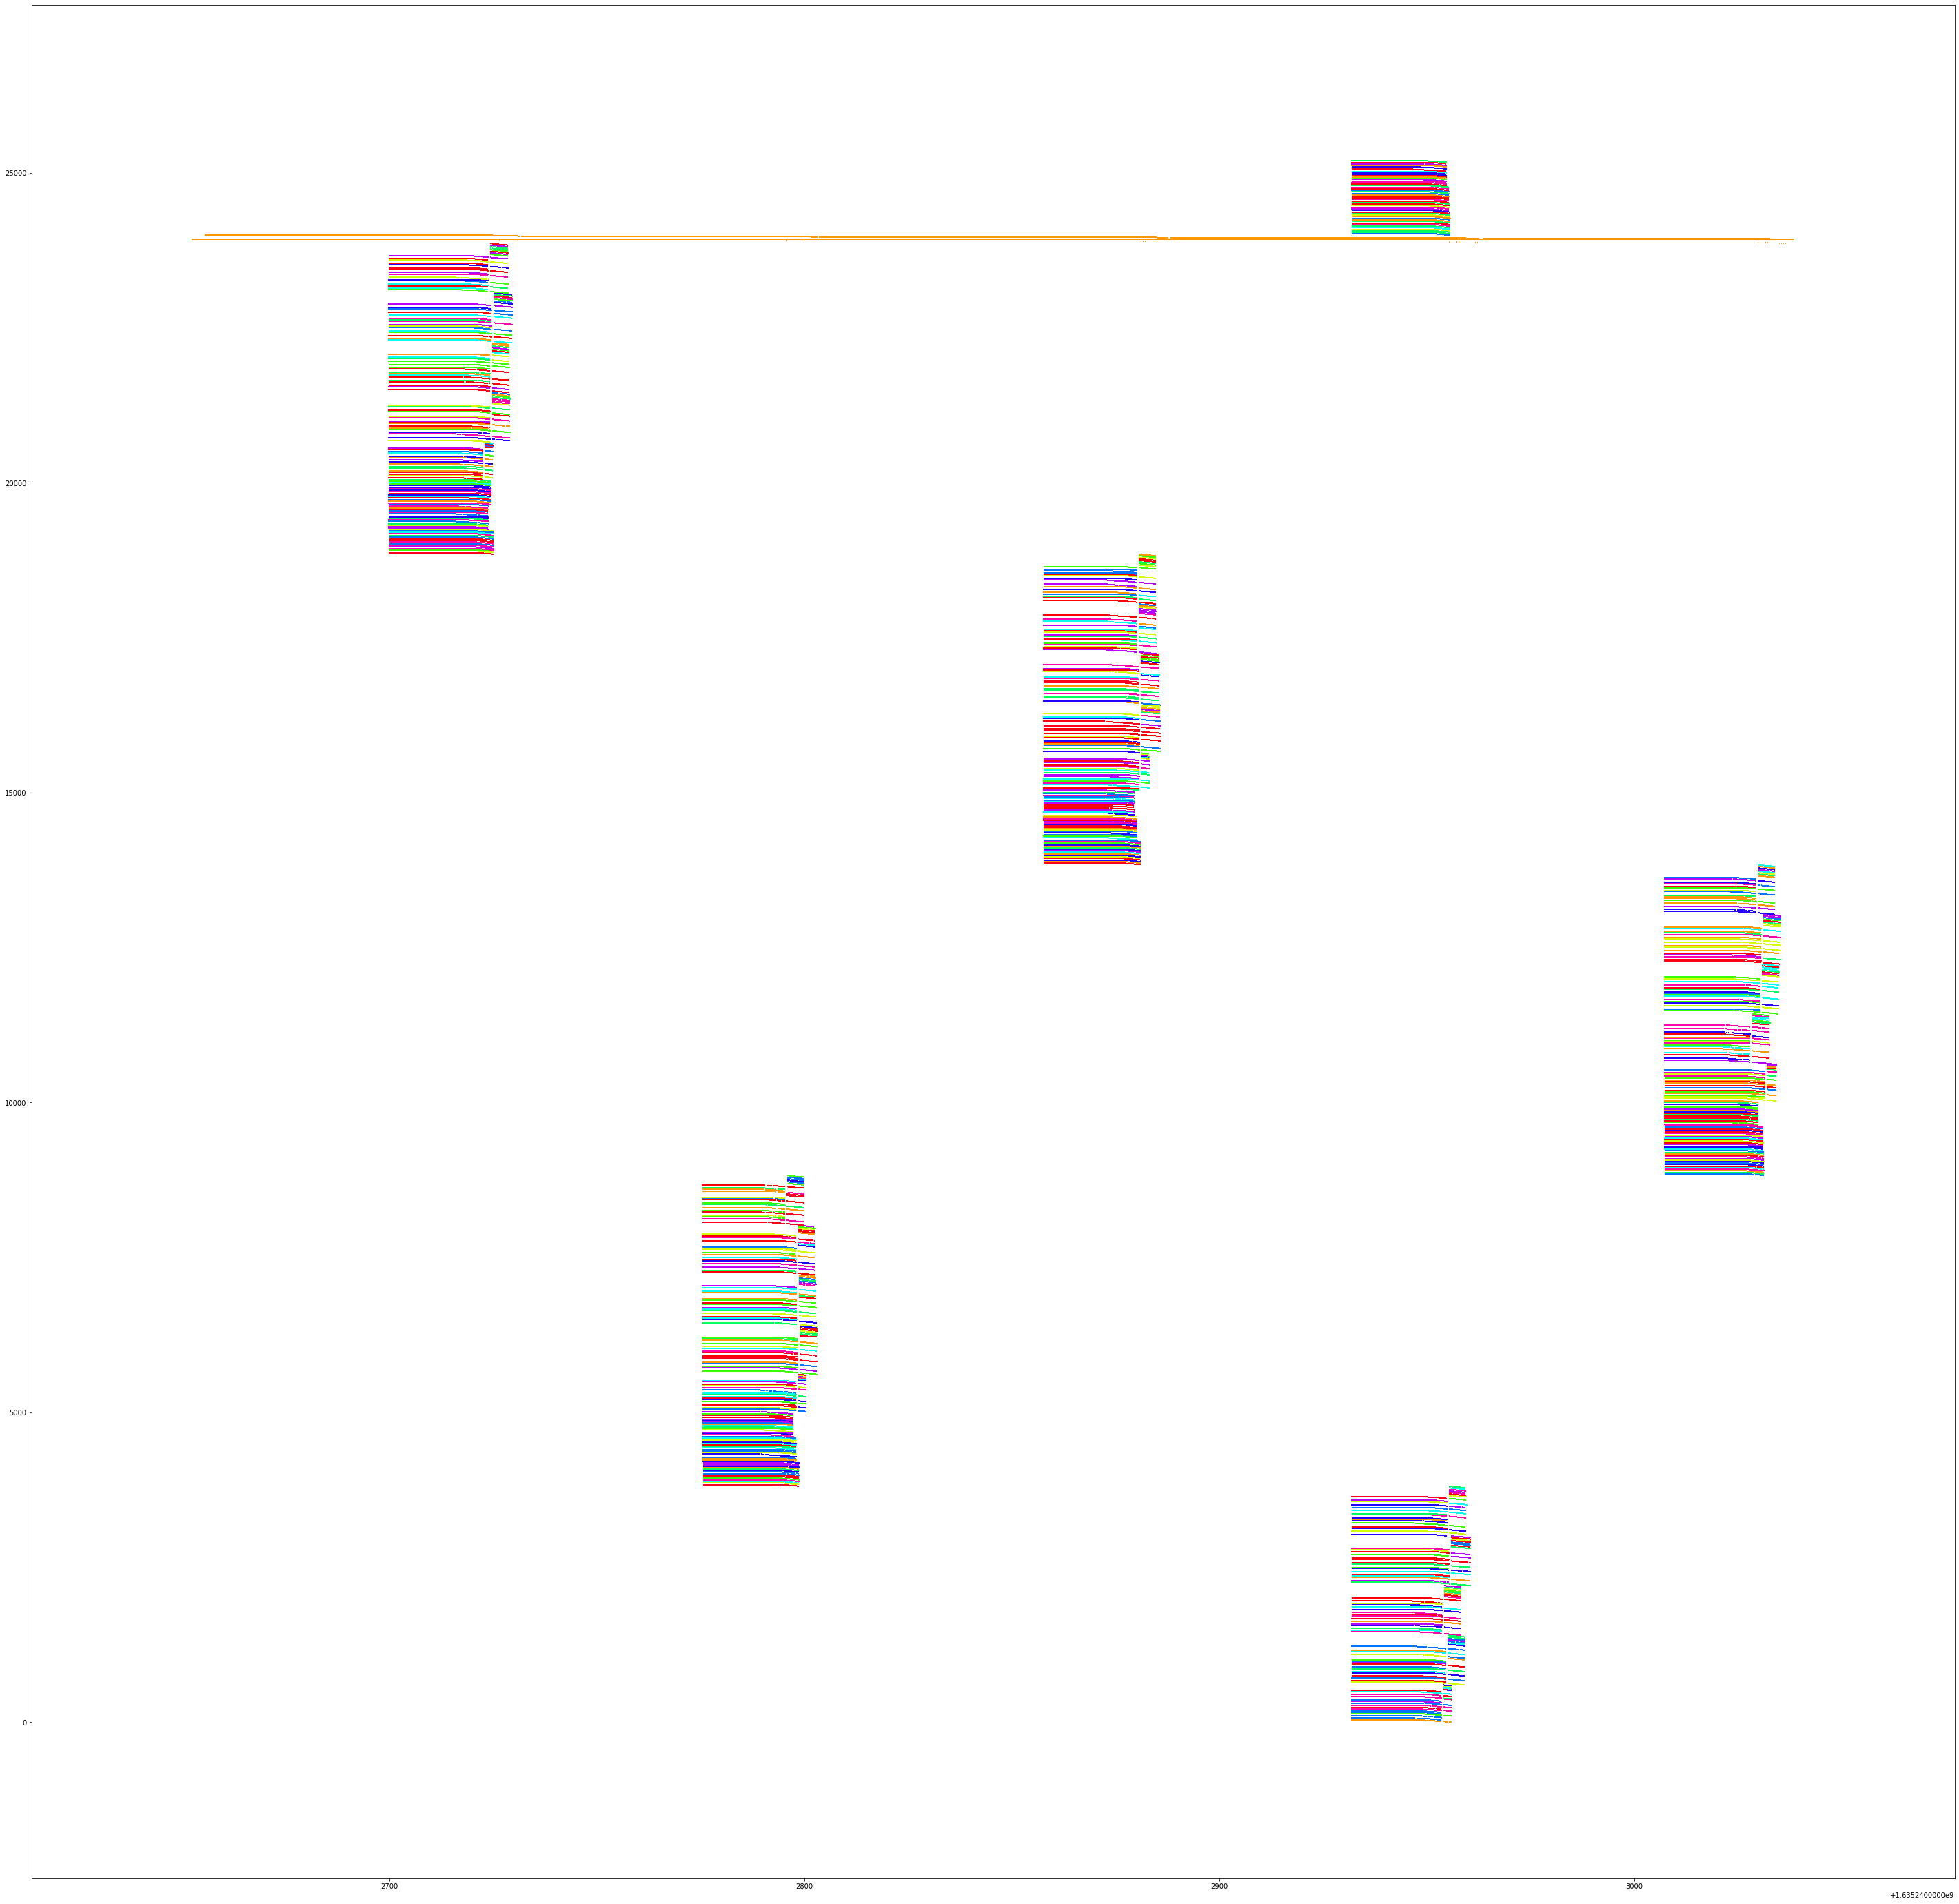

In [172]:
# ['__getitem__' '_worker_loop' 'advance' 'batch_to_device' 'fetch' 'start_train']

run = df_dataloader_threaded[(df_dataloader_threaded["num_workers"]==8) & 
                             (df_dataloader_threaded["batch_size"]==400)]["run"].iloc[0]
len(run)
print(run)
print(batch_sizes)
plot_events_timeline_detailed(df_dataloader_threaded[df_dataloader_threaded["run"]==run], 
                              filter_function="__getitem__")

plot_events_timeline_detailed(df_dataloader_threaded[df_dataloader_threaded["run"]==run], 
                              filter_function="advance")

plot_events_timeline_detailed(df_dataloader_threaded[df_dataloader_threaded["run"]==run], 
                              filter_function="batch_to_device")

plot_events_timeline(df_dataloader_threaded[df_dataloader_threaded["run"]==run])

In [173]:
#### run = df_dataloader_vanilla[(df_dataloader_vanilla["num_workers"]==8) & 
                             (df_dataloader_vanilla["batch_size"]==3)]["run"].iloc[0]
len(run)
plot_events_timeline_detailed(df_dataloader_vanilla[df_dataloader_vanilla["run"]==run], 
                              filter_function="__getitem__")

plot_events_timeline_detailed(df_dataloader_vanilla[df_dataloader_vanilla["run"]==run], 
                              filter_function="advance")

plot_events_timeline(df_dataloader_vanilla[df_dataloader_vanilla["run"]==run])


IndentationError: unexpected indent (185536426.py, line 2)

### RATE

In [174]:
s3_both

,batch_size,num_fetch_workers,num_workers,a_rate,a_gpu,pf,t_rate,t_gpu,v_rate,v_gpu
0,200,[16],[8],55.5,85.0,16.0,59.0,67.5,37.8,83.0
1,400,[16],[8],47.2,68.0,16.0,58.2,74.0,33.8,82.5
2,800,[16],[8],52.1,72.0,16.0,60.5,65.0,23.5,62.0


In [175]:
batch_sizes

array([200, 400, 800])

In [176]:
def plot_stats(d1):   
    fig, ax = plt.subplots(figsize=(15, 10))
#     ax.axis(ymin=100, ymax=345)
    for i, (batch_size, color) in enumerate(zip(batch_sizes, ["red"])):
        current_batch = d1[d1["batch_size"]==batch_size]
#         current_batch = current_batch.sort_values(["batch_size"], ascending=True)
        xrange = 0
        ax.bar(x=i+xrange, height=current_batch["a_rate"], width=0.25, color=color, label=f"A-rate, {batch_size}")
        ax.bar(x=i+xrange+0.3, height=current_batch["t_rate"], hatch="xxx", color=color, width=0.25, label=f"T-Rate, {batch_size}")
        ax.bar(x=i+xrange+0.6, height=current_batch["v_rate"], hatch="...", color=color, width=0.25, label=f"V-Rate, {batch_size}")
        print(current_batch["a_rate"])
    
    ax.grid(linestyle='--', which="both")
    ax.set_xticklabels([0] + batch_sizes, fontdict=None)

    del current_batch
    ax.set_xlabel(f"batch size", loc="center")
    ax.set_ylabel("Rate", loc="top")
    ax.set_title(f"S3 Asyncio vs. Threaded vs. Vanilla Pytorch + Batch sizes", loc='center')
    ax.legend()


0    55.5
Name: a_rate, dtype: float64


/tmp/ipykernel_22331/2366593411.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + batch_sizes, fontdict=None)


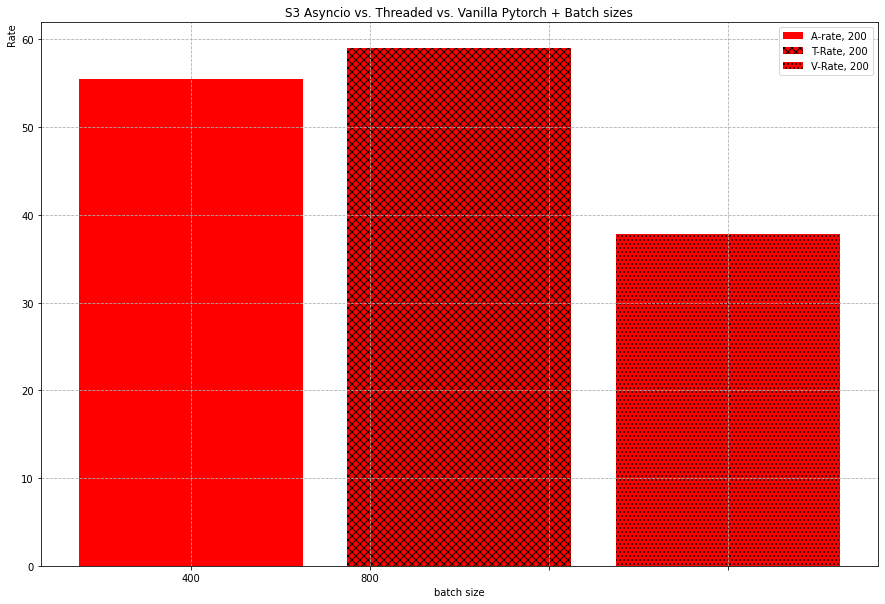

In [177]:
plot_stats(s3_both)

!!! **Vannila is good with many workers and small batches!**

In [178]:
#f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["function_name"]=="__getitem__"]
#f_df_dataloader_s3_threaded=df_dataloader_s3_threaded[df_dataloader_s3_threaded["function_name"]=="__getitem__"]
#f_df_dataloader_s3_vanilla=df_dataloader_s3_vanilla[df_dataloader_s3_vanilla["function_name"]=="__getitem__"]

In [179]:
print(np.unique(df_dataloader_s3_async["function_name"].to_numpy()))

['__getitem__' 'advance' 'batch_to_device' 'fetch' 'start_train']


In [180]:
df_dataloader_s3_async["prefetch_factor"]

0        16
1        16
2        16
3        16
4        16
         ..
75673    16
75674    16
75675    16
75676    16
75677    16
Name: prefetch_factor, Length: 75678, dtype: int64

In [181]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [182]:
# fn = "__getitem__"
def plot_stats(fn, show_mean=False, ymax=None):
#     fig, ax = plt.subplots(figsize=(15, 10))
#     ax.axis(ymin=100, ymax=345)
    for bs in batch_sizes:
        skip_time = 10
        f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["function_name"]==fn]
        f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["batch_size"]==bs]
        f_df_dataloader_s3_async=f_df_dataloader_s3_async.sort_values(["num_workers"], ascending=False)

        f_df_dataloader_s3_threaded=df_dataloader_s3_threaded[df_dataloader_s3_threaded["function_name"]==fn]
        f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["batch_size"]==bs]
        f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded.sort_values(["num_workers"], ascending=False)

        f_df_dataloader_s3_vanilla=df_dataloader_s3_vanilla[df_dataloader_s3_vanilla["function_name"]==fn]
        f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["batch_size"]==bs]
        f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla.sort_values(["num_workers"], ascending=False)
    
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.plot(range(len(f_df_dataloader_s3_async)), f_df_dataloader_s3_async["elapsed"],color="red",label="async")
        ax.plot(range(len(f_df_dataloader_s3_threaded)), f_df_dataloader_s3_threaded["elapsed"],color="blue",label="threaded")
        ax.plot(range(len(f_df_dataloader_s3_vanilla)), f_df_dataloader_s3_vanilla["elapsed"],color="green",label="vanilla")
    
        
        if show_mean:
            ax.axhline(y=f_df_dataloader_s3_async["elapsed"].mean(),color="red", linestyle="--",label="async mean")
            ax.axhline(y=f_df_dataloader_s3_threaded["elapsed"].mean(),color="blue", linestyle="--",label="threaded mean")
            ax.axhline(y=f_df_dataloader_s3_vanilla["elapsed"].mean(),color="green", linestyle="--",label="vanilla mean")
        
        del f_df_dataloader_s3_vanilla
        del f_df_dataloader_s3_threaded
        del f_df_dataloader_s3_async
        ax.set_xlabel(f"Experiment", loc="center")
        ax.set_ylabel("Duration (s)", loc="top")
        ax.set_title(f"{fn}, {bs}", loc='center')
        ax.legend()

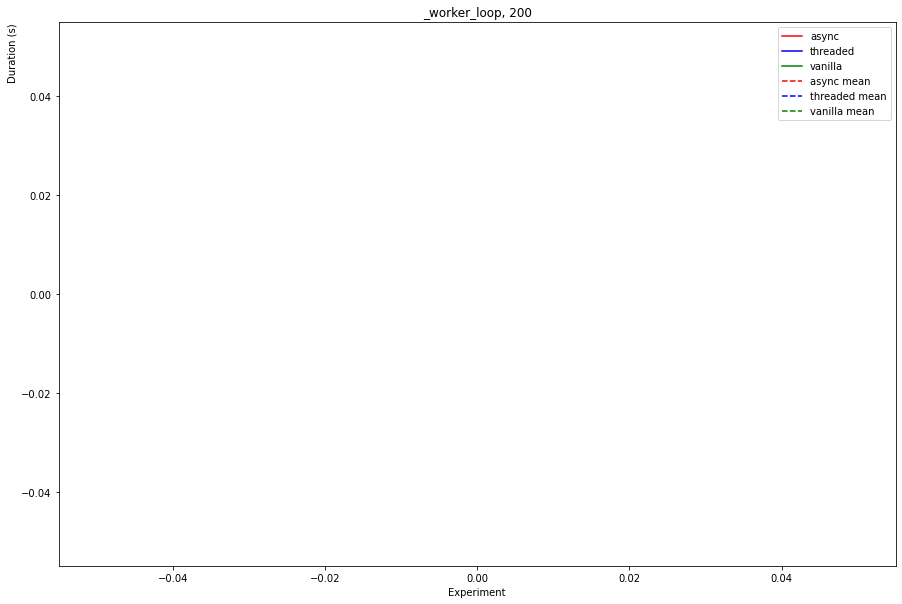

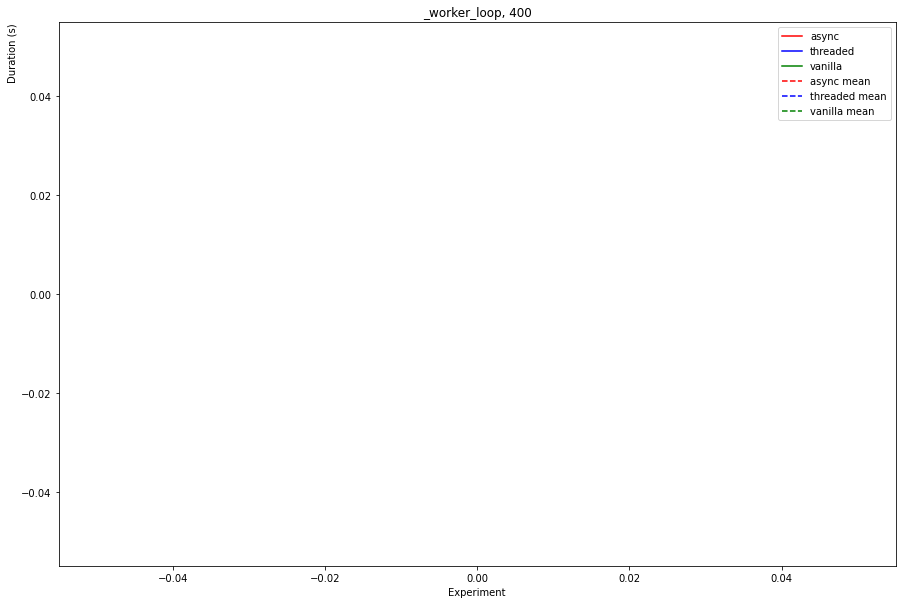

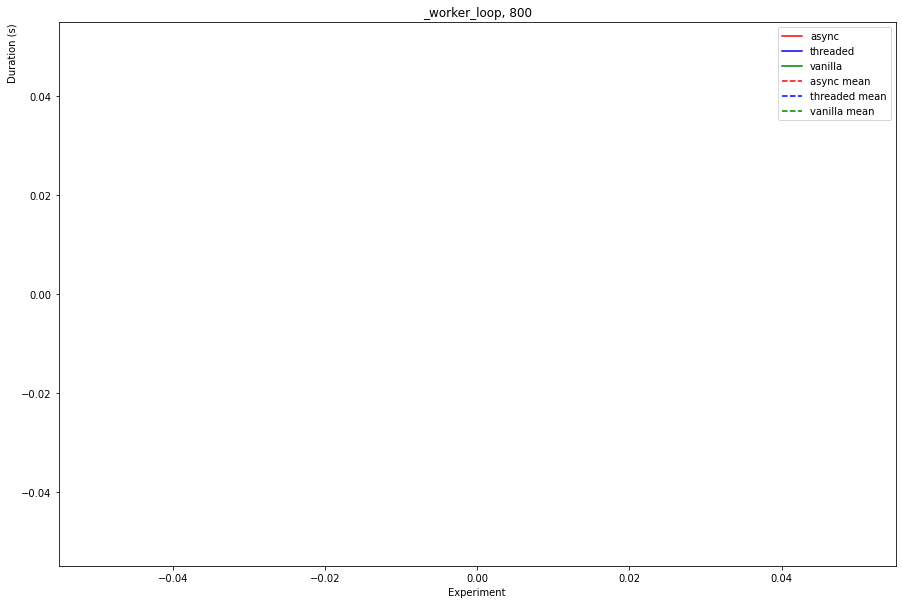

In [183]:
plot_stats("_worker_loop", True)

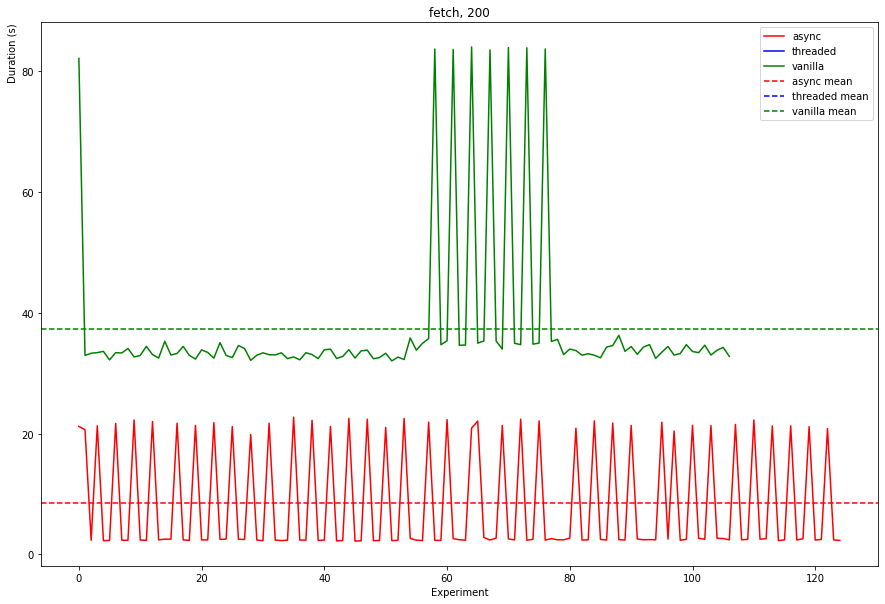

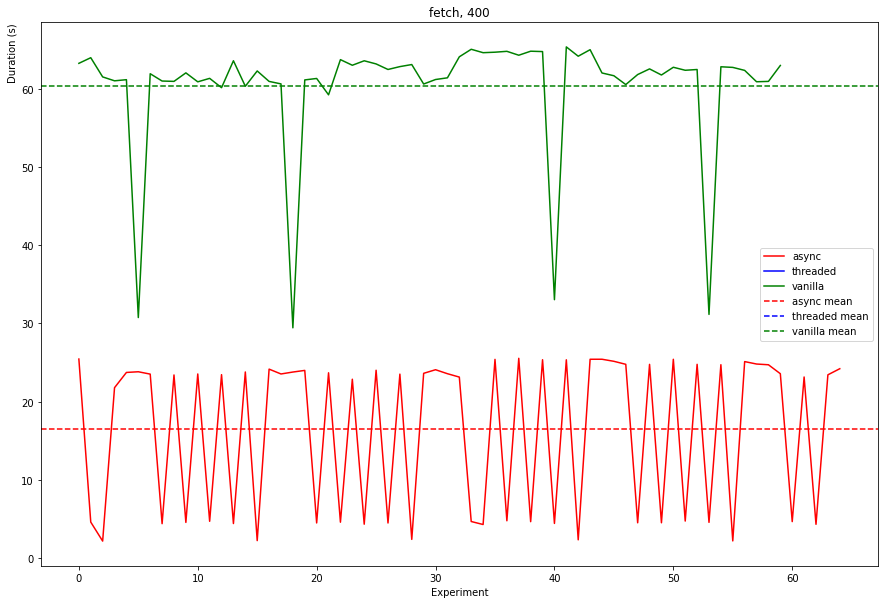

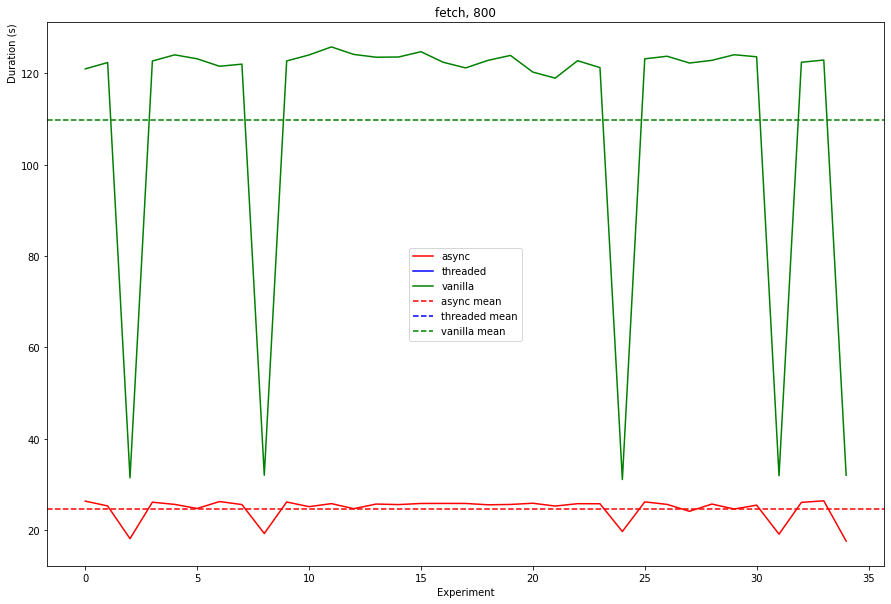

In [184]:
plot_stats("fetch", True)

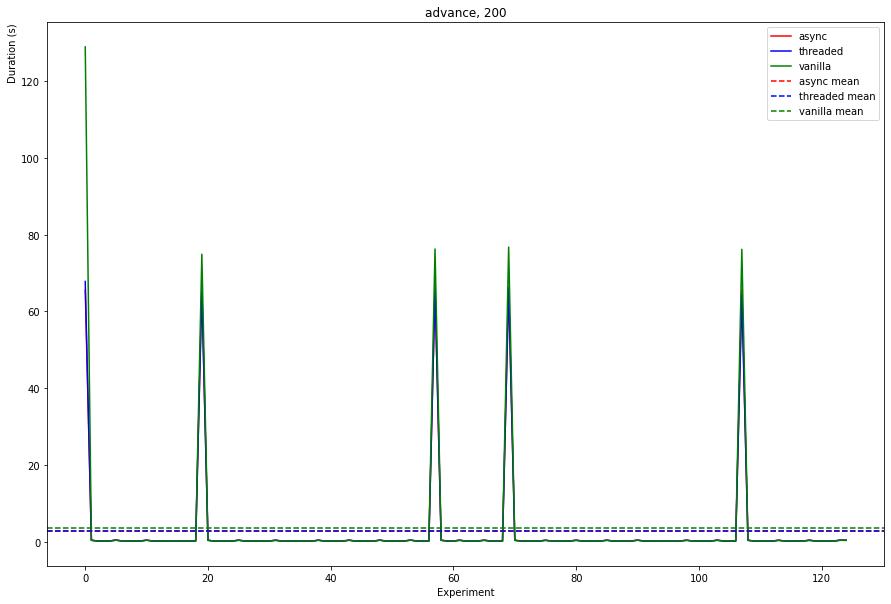

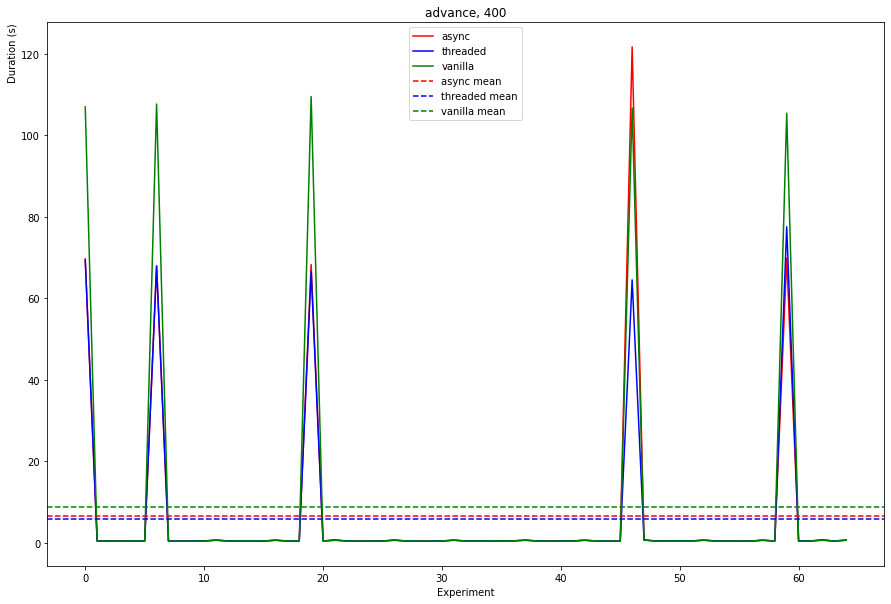

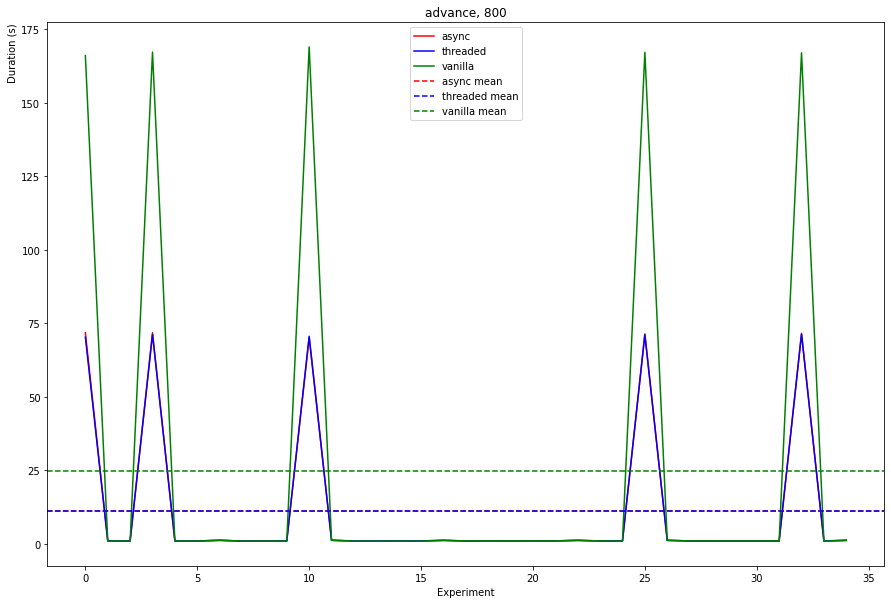

In [185]:
plot_stats("advance", True)

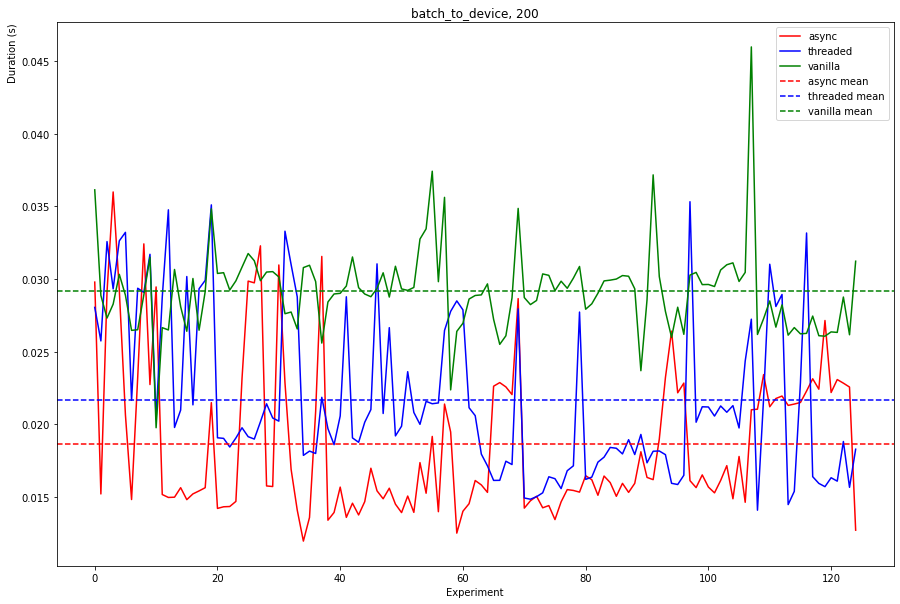

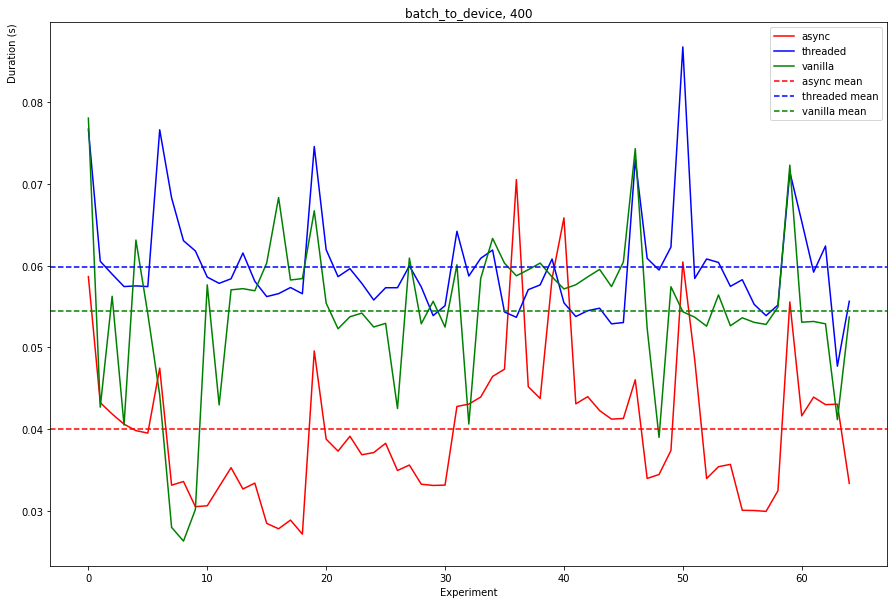

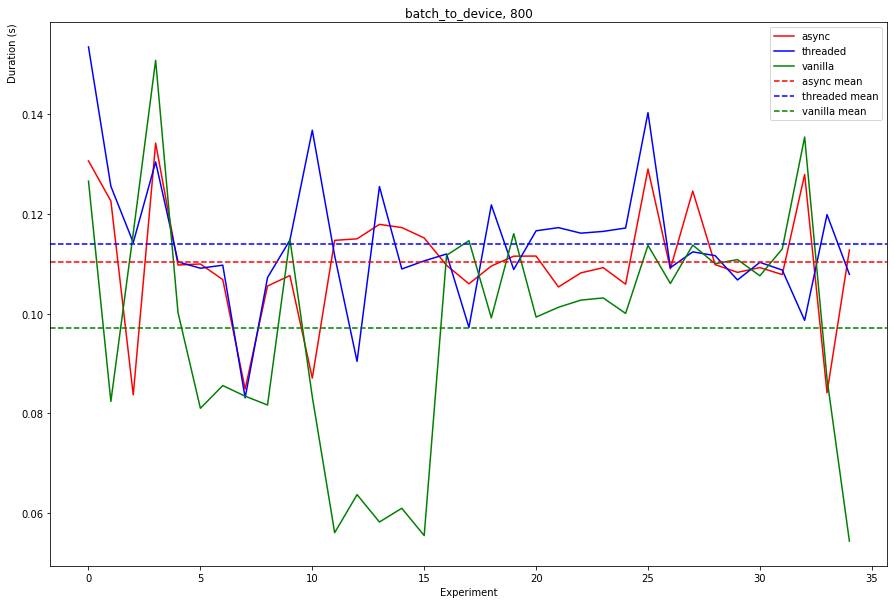

In [186]:
plot_stats("batch_to_device", True)

### GPU Utilization

In [187]:
def plot_gpu_stats(d1):   
#     ax.axis(ymin=0.003, ymax=0.012)
    fig, ax = plt.subplots(figsize=(15, 10))
    for i, (batch_size, color) in enumerate(zip(batch_sizes, 
                                                ["red", "gray", "lime", "aqua", "yellow", "green", "gold"])):
        s3_fix_1 = d1[d1["batch_size"]==batch_size]
        ax.bar(x=i, height=s3_fix_1["a_gpu"], width=0.25, color=color, label=f"A-util, {batch_size}")
        ax.bar(x=i+0.3, height=s3_fix_1["t_gpu"], hatch="xxx", color=color, width=0.25, label=f"T-util, {batch_size}")
        ax.bar(x=i+0.6, height=s3_fix_1["v_gpu"], hatch="...", color=color, width=0.25, label=f"V-util, {batch_size}")

    ax.grid(linestyle='--', which="both")

    ax.set_xlabel(f"Batch sizes", loc="center")
    ax.set_ylabel("GPU Util", loc="top")
    ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)
    ax.set_title(f"", loc='center')
    ax.legend()

/tmp/ipykernel_22331/891893924.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)


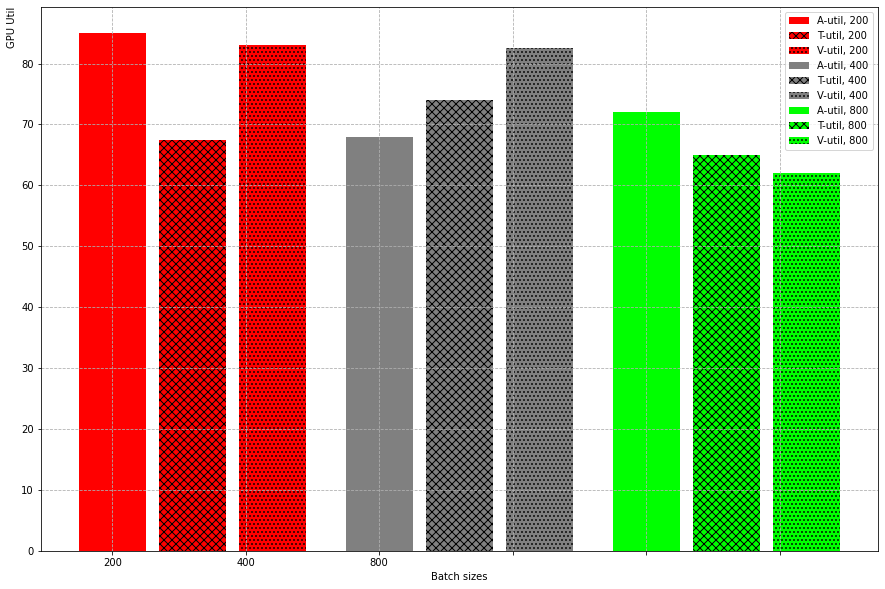

In [188]:
plot_gpu_stats(s3_both)

### Batch download - sum

In [189]:
df_s3_gpu_util

,run,gpu,gpu_mean,gpu_median,std
0,20211026f112518_benchmark_e2e_s3_200_8_16_sync,"[60.0, 70.0, 63.0, 62.0, 42.0, 44.0, 34.0, 52....",72.500000,83.0,26.030943
1,20211026f113329_benchmark_e2e_s3_400_8_16_sync,"[20.0, 74.0, 69.0, 100.0, 100.0, 70.0, 48.0, 9...",74.076923,82.5,27.175955
2,20211026f114311_benchmark_e2e_s3_800_8_16_sync,"[58.0, 88.0, 29.0, 71.0, 17.0, 36.0, 57.0, 99....",62.500000,62.0,25.811819
3,20211026f115752_benchmark_e2e_s3_200_8_16_sync,"[47.0, 66.0, 48.0, 66.0, 37.0, 91.0, 94.0, 97....",70.840000,67.5,24.150660
4,20211026f120411_benchmark_e2e_s3_400_8_16_sync,"[73.0, 100.0, 100.0, 67.0, 10.0, 75.0, 23.0, 8...",69.807692,74.0,29.650554
5,20211026f121045_benchmark_e2e_s3_800_8_16_sync,"[74.0, 100.0, 42.0, 84.0, 24.0, 96.0, 25.0, 65...",62.928571,65.0,27.022383
6,20211026f121726_benchmark_e2e_s3_200_8_16_sync,"[66.0, 85.0, 54.0, 63.0, 32.0, 60.0, 100.0, 10...",74.600000,85.0,26.329451
7,20211026f122344_benchmark_e2e_s3_400_8_16_sync,"[86.0, 100.0, 29.0, 71.0, 53.0, 52.0, 32.0, 84...",68.423077,68.0,26.096232
8,20211026f123106_benchmark_e2e_s3_800_8_16_sync,"[64.0, 100.0, 29.0, 80.0, 19.0, 100.0, 50.0, 1...",69.214286,72.0,28.488540


In [190]:
type(df_s3_gpu_util)

pandas.core.frame.DataFrame

In [191]:
# fn = "__getitem__"
def plot_stats2(fn, show_mean=False, ymax=None):
#     fig, ax = plt.subplots(figsize=(15, 10))
#     ax.axis(ymin=100, ymax=345)

    for bs in batch_sizes:
        all_async = []
        all_threaded = []
        all_vanilla = []
        for index, row in df_s3_gpu_util.iterrows():
            skip_time = 10
            f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["run"]==row["run"]]
            mean_async = f_df_dataloader_s3_async["elapsed"].mean()
            f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["elapsed"]<=mean_async*1.2]
            f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["batch_size"]==bs]
            f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["function_name"]==fn]
            f_df_dataloader_s3_async=f_df_dataloader_s3_async.sort_values(["num_workers"], ascending=False)
            all_async += list(f_df_dataloader_s3_async["elapsed"])
            del f_df_dataloader_s3_async
            
            f_df_dataloader_s3_threaded=df_dataloader_s3_threaded[df_dataloader_s3_threaded["run"]==row["run"]]
            mean_threaded = f_df_dataloader_s3_threaded["elapsed"].mean()
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["elapsed"]<=mean_threaded*1.2]
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["batch_size"]==bs]
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["function_name"]==fn]
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded.sort_values(["num_workers"], ascending=False)
            all_threaded += list(f_df_dataloader_s3_threaded["elapsed"])
            del f_df_dataloader_s3_threaded
            
            f_df_dataloader_s3_vanilla=df_dataloader_s3_vanilla[df_dataloader_s3_vanilla["run"]==row["run"]]
            mean_vanilla = f_df_dataloader_s3_vanilla["elapsed"].mean()
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["elapsed"]<=mean_vanilla*1.2]
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["batch_size"]==bs]
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["function_name"]==fn]
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla.sort_values(["num_workers"], ascending=False)
            all_vanilla += list(f_df_dataloader_s3_vanilla["elapsed"])
            del f_df_dataloader_s3_vanilla
        
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.plot(range(len(all_async)), all_async, color="red",label="async")
        ax.plot(range(len(all_threaded)), all_threaded, color="blue",label="threaded")
        ax.plot(range(len(all_vanilla)), all_vanilla, color="green",label="vanilla")
     
    del all_async
    del all_vanilla
    del mean_threaded
    ax.set_xlabel(f"Experiment", loc="center")
    ax.set_ylabel("Duration (s)", loc="top")
    ax.set_title(f"{fn}, {bs}", loc='center')
    ax.legend()

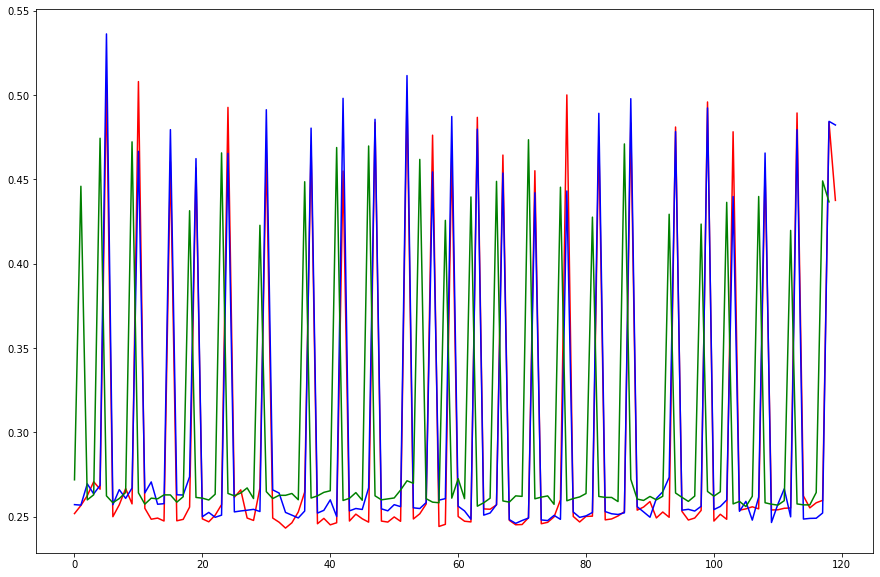

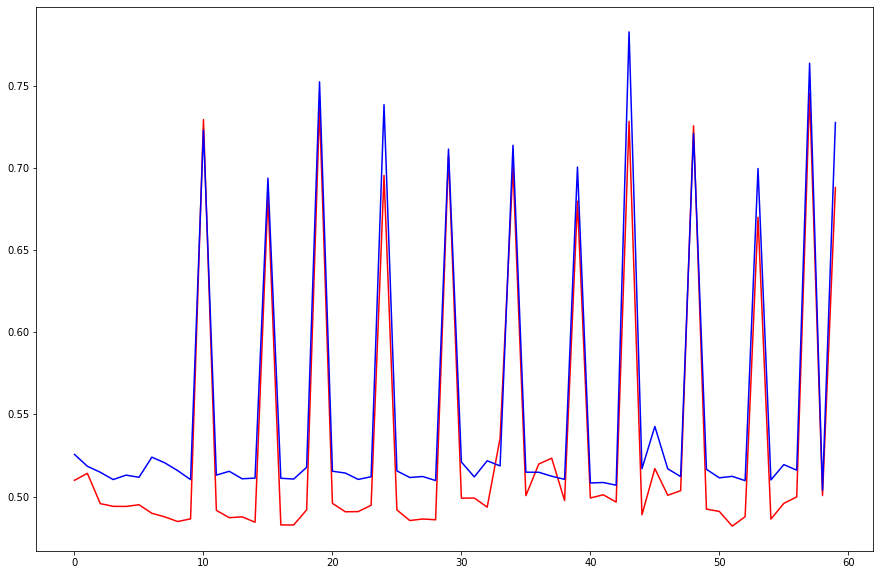

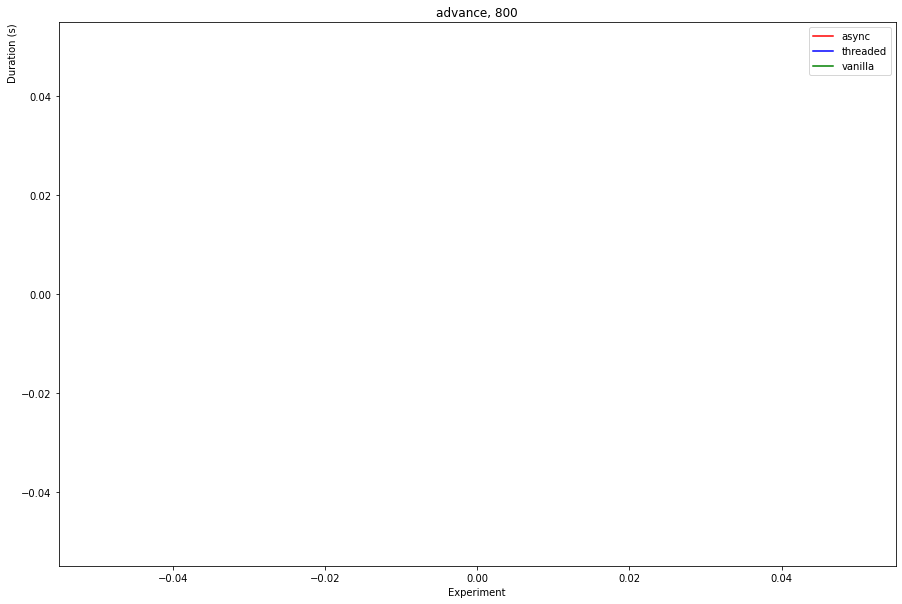

In [192]:
plot_stats2("advance", True)

IT is not only the experiment start, it is the EPOCH download start... 5 times, for each batch example

In [200]:
df_dataloader_s3_async

,trace_name,trace_level,function_name,elapsed,time_start,time_end,process_time,process_time_start,process_time_end,pid,...,release,version,machine,source_file,run,len,gpu,gpu_mean,gpu_median,std
0,(8)-batch-to-device,8,batch_to_device,0.029781,1.635244e+09,1.635244e+09,0.029815,10.194593,10.224408,2818,...,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f121726_benchmark_e2e_s3_200_8_16_sync,NaN,"[66.0, 85.0, 54.0, 63.0, 32.0, 60.0, 100.0, 10...",74.600000,85.0,26.329451
1,(6)-advance,6,advance,65.578406,1.635243e+09,1.635244e+09,4.070050,6.471341,10.541391,2818,...,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f121726_benchmark_e2e_s3_200_8_16_sync,NaN,"[66.0, 85.0, 54.0, 63.0, 32.0, 60.0, 100.0, 10...",74.600000,85.0,26.329451
2,(8)-batch-to-device,8,batch_to_device,0.015812,1.635244e+09,1.635244e+09,0.015808,10.541649,10.557457,2818,...,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f121726_benchmark_e2e_s3_200_8_16_sync,NaN,"[66.0, 85.0, 54.0, 63.0, 32.0, 60.0, 100.0, 10...",74.600000,85.0,26.329451
3,(6)-advance,6,advance,0.251804,1.635244e+09,1.635244e+09,0.251213,10.541593,10.792806,2818,...,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f121726_benchmark_e2e_s3_200_8_16_sync,NaN,"[66.0, 85.0, 54.0, 63.0, 32.0, 60.0, 100.0, 10...",74.600000,85.0,26.329451
4,(8)-batch-to-device,8,batch_to_device,0.018969,1.635244e+09,1.635244e+09,0.019012,10.793185,10.812196,2818,...,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f121726_benchmark_e2e_s3_200_8_16_sync,NaN,"[66.0, 85.0, 54.0, 63.0, 32.0, 60.0, 100.0, 10...",74.600000,85.0,26.329451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75673,(5)-get_item,5,__getitem__,0.138976,1.635245e+09,1.635245e+09,0.178297,9.786233,9.964530,19924,...,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f123106_benchmark_e2e_s3_800_8_16_sync,23451.0,"[64.0, 100.0, 29.0, 80.0, 19.0, 100.0, 50.0, 1...",69.214286,72.0,28.488540
75674,(5)-get_item,5,__getitem__,0.188415,1.635245e+09,1.635245e+09,0.231616,9.735922,9.967539,19924,...,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f123106_benchmark_e2e_s3_800_8_16_sync,209297.0,"[64.0, 100.0, 29.0, 80.0, 19.0, 100.0, 50.0, 1...",69.214286,72.0,28.488540
75675,(5)-get_item,5,__getitem__,0.199769,1.635245e+09,1.635245e+09,0.257301,9.711025,9.968326,19924,...,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f123106_benchmark_e2e_s3_800_8_16_sync,20112.0,"[64.0, 100.0, 29.0, 80.0, 19.0, 100.0, 50.0, 1...",69.214286,72.0,28.488540
75676,(5)-get_item,5,__getitem__,0.134605,1.635245e+09,1.635245e+09,0.138948,9.840464,9.979413,19924,...,4.19.0-18-amd64,#1 SMP Debian 4.19.208-1 (2021-09-29),x86_64,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211026f123106_benchmark_e2e_s3_800_8_16_sync,120469.0,"[64.0, 100.0, 29.0, 80.0, 19.0, 100.0, 50.0, 1...",69.214286,72.0,28.488540


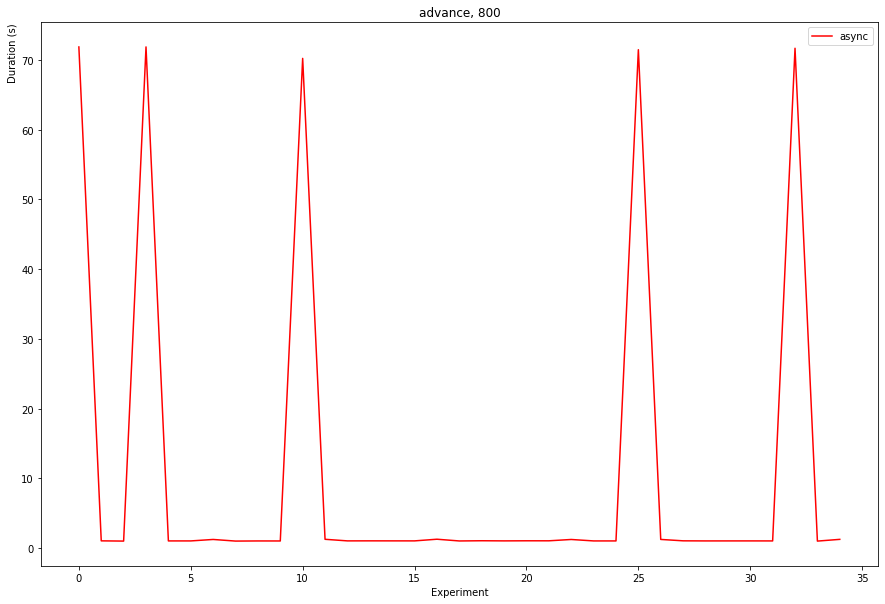

In [202]:

fn = "advance"
bs = 800
all_async = []
f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["run"]=="20211026f123106_benchmark_e2e_s3_800_8_16_sync"]
mean_async = f_df_dataloader_s3_async["elapsed"].mean()
f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["batch_size"]==bs]
f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["function_name"]==fn]
f_df_dataloader_s3_async=f_df_dataloader_s3_async.sort_values(["num_workers"], ascending=False)
# \\\
all_async += list(f_df_dataloader_s3_async["elapsed"])
del f_df_dataloader_s3_async

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(range(len(all_async)), all_async, color="red",label="async")

del all_async
ax.set_xlabel(f"Experiment", loc="center")
ax.set_ylabel("Duration (s)", loc="top")
ax.set_title(f"{fn}, {bs}", loc='center')
ax.legend()

In [208]:
output_base_folder

PosixPath('/iarai/home/ivan.svogor/git/storage-benchmarking/src/benchmark_output')

In [207]:
profiling = extract_profiling(output_base_folder, folder_filter=s3_folder_filter,device_id=2)

<generator object Path.rglob at 0x7faf6be7a510>


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.24s/it]


In [204]:
# profiling.drop('NaN', axis=1, inplace=True)

In [209]:
prof_async = pd.merge(df_dataloader_async, profiling, left_on='run', right_on='run')
prof_threaded = pd.merge(df_dataloader_threaded, profiling, left_on='run', right_on='run')
prof_vanilla = pd.merge(df_dataloader_vanilla, profiling, left_on='run', right_on='run')

In [210]:
s3_both

,batch_size,num_fetch_workers,num_workers,a_rate,a_gpu,pf,t_rate,t_gpu,v_rate,v_gpu
0,200,[16],[8],55.5,85.0,16.0,59.0,67.5,37.8,83.0
1,400,[16],[8],47.2,68.0,16.0,58.2,74.0,33.8,82.5
2,800,[16],[8],52.1,72.0,16.0,60.5,65.0,23.5,62.0


In [211]:
p = profiling[(profiling["function"]=="run_training_epoch") | 
              (profiling["function"]=="get_train_batch") |
              (profiling["function"]=="training_step_and_backward") |
              (profiling["function"]=="model_forward") | 
              (profiling["function"]=="training_step") |
              (profiling["function"]=="backward") |
              (profiling["function"]=="run_training_batch")]

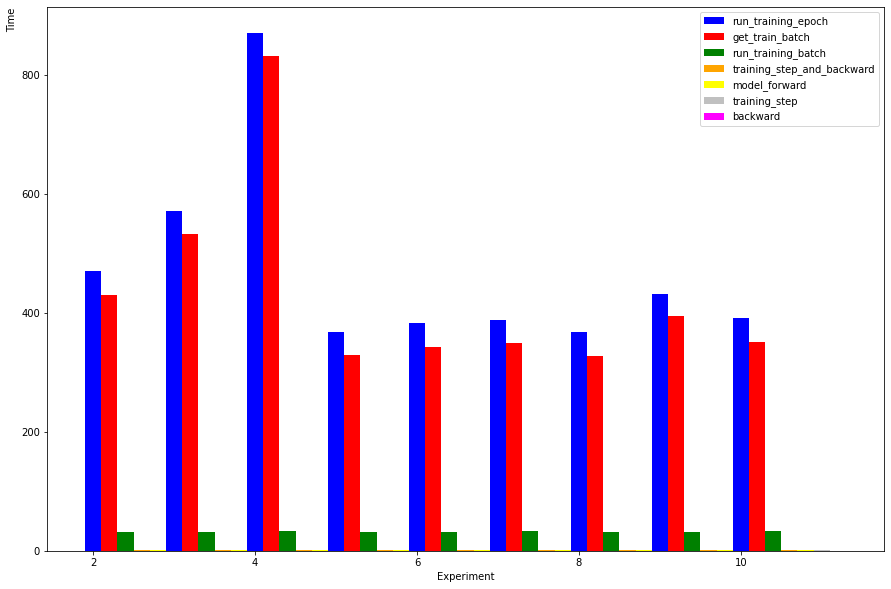

In [212]:
runs = list(p.drop_duplicates(subset = ["run"])["run"])
fig, ax = plt.subplots(figsize=(15, 10))
for i, run in enumerate(runs):
    items = p[p["run"]==run]
    run_training_epoch = items[items["function"]=="run_training_epoch"]
    get_train_batch = items[items["function"]=="get_train_batch"]
    run_training_batch = items[items["function"]=="run_training_batch"]
    training_step_and_backward = items[items["function"]=="training_step_and_backward"]
    model_forward = items[items["function"]=="model_forward"]
    training_step = items[items["function"]=="training_step"]
    backward = items[items["function"]=="backward"]
    ax.bar(x=i + 2 + 0,   height=run_training_epoch["total_time"], width=0.2, color="blue", label="run_training_epoch")
    ax.bar(x=i + 2 + 0.2, height=get_train_batch["total_time"], width=0.2, color="red", label="get_train_batch")
    ax.bar(x=i + 2 + 0.4, height=run_training_batch["total_time"], width=0.2, color="green", label="run_training_batch")
    ax.bar(x=i + 2 + 0.6, height=training_step_and_backward["total_time"], width=0.2, color="orange", label="training_step_and_backward")
    ax.bar(x=i + 2 + 0.8, height=model_forward["total_time"], width=0.2, color="yellow", label="model_forward")
    ax.bar(x=i + 2 + 1.0, height=training_step["total_time"], width=0.2, color="silver", label="training_step")
    ax.bar(x=i + 2 + 1.2, height=backward["total_time"], width=0.2, color="magenta", label="backward")
ax.set_xlabel(f"Experiment", loc="center")
ax.set_ylabel("Time", loc="top")
ax.set_title(f"", loc='center')
ax.legend()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

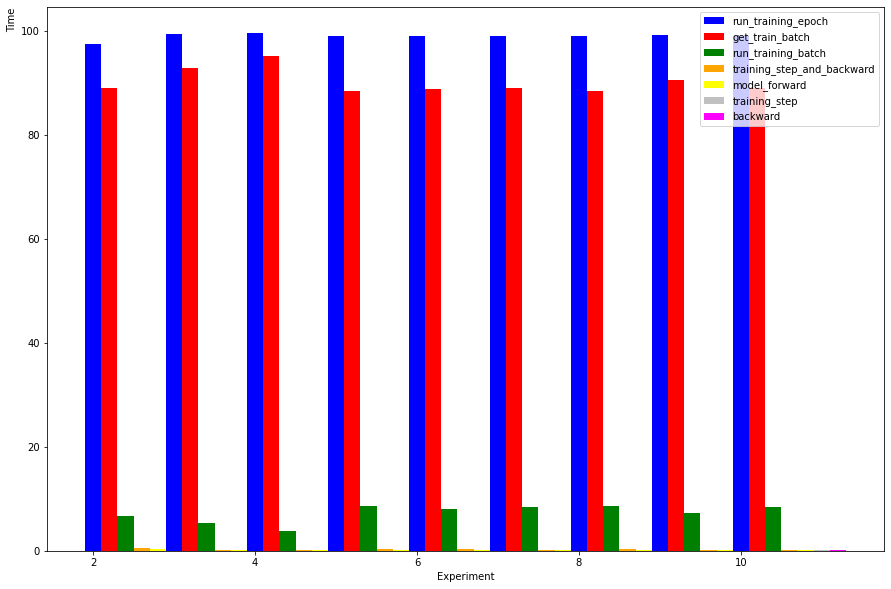

In [213]:
runs = list(p.drop_duplicates(subset = ["run"])["run"])
fig, ax = plt.subplots(figsize=(15, 10))
for i, run in enumerate(runs):
    items = p[p["run"]==run]
    run_training_epoch = items[items["function"]=="run_training_epoch"]
    get_train_batch = items[items["function"]=="get_train_batch"]
    run_training_batch = items[items["function"]=="run_training_batch"]
    training_step_and_backward = items[items["function"]=="training_step_and_backward"]
    model_forward = items[items["function"]=="model_forward"]
    training_step = items[items["function"]=="training_step"]
    backward = items[items["function"]=="backward"]
    ax.bar(x=i + 2 + 0,   height=run_training_epoch["percentage"], width=0.2, color="blue", label="run_training_epoch")
    ax.bar(x=i + 2 + 0.2, height=get_train_batch["percentage"], width=0.2, color="red", label="get_train_batch")
    ax.bar(x=i + 2 + 0.4, height=run_training_batch["percentage"], width=0.2, color="green", label="run_training_batch")
    ax.bar(x=i + 2 + 0.6, height=training_step_and_backward["percentage"], width=0.2, color="orange", label="training_step_and_backward")
    ax.bar(x=i + 2 + 0.8, height=model_forward["percentage"], width=0.2, color="yellow", label="model_forward")
    ax.bar(x=i + 2 + 1.0, height=training_step["percentage"], width=0.2, color="silver", label="training_step")
    ax.bar(x=i + 2 + 1.2, height=backward["percentage"], width=0.2, color="magenta", label="backward")
ax.set_xlabel(f"Experiment", loc="center")
ax.set_ylabel("Time", loc="top")
ax.set_title(f"", loc='center')
ax.legend()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [215]:
run = df_dataloader_threaded[(df_dataloader_threaded["num_workers"]==8) & 
                             (df_dataloader_threaded["batch_size"]==800)]["run"].iloc[0]

runv = df_dataloader_vanilla[(df_dataloader_vanilla["num_workers"]==8) & 
                             (df_dataloader_vanilla["batch_size"]==800)]["run"].iloc[0]


# f_df_dataloader_threaded=df_dataloader_threaded[df_dataloader_threaded["run"]==run]

In [216]:
fn = "advance"
df=df_dataloader_threaded[df_dataloader_threaded["run"]==run]
mean_threaded = f_df_dataloader_threaded["elapsed"].mean()
df=df[df["function_name"]==fn]
df=df.sort_values(["num_workers"], ascending=False)
all_threaded = list(df["elapsed"])
del df

df=df_dataloader_vanilla[df_dataloader_vanilla["run"]==runv]
mean_vanilla = df_dataloader_vanilla["elapsed"].mean()
df=df[df["function_name"]==fn]
df=df.sort_values(["num_workers"], ascending=False)
all_vanilla = list(df["elapsed"])
del df

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(range(len(all_threaded)), all_threaded, color="blue",label="threaded")
ax.plot(range(len(all_vanilla)), all_vanilla, color="red",label="vanilla")

del mean_threaded
del mean_vanilla
ax.set_xlabel(f"Step", loc="center")
ax.set_ylabel("Duration (s)", loc="top")
ax.set_title(f"{fn}, {bs}", loc='center')
ax.legend()

NameError: name 'f_df_dataloader_threaded' is not defined